# Setup

In [110]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from global_land_mask import globe
from scipy.stats import linregress
from scipy.linalg import lstsq
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

# Define Constants
prctl_bins = np.arange(0,105,5) # bottom edge of percentile bins
prctl_binmids = (prctl_bins[:-1]+prctl_bins[1:])/2 # center of percentile bins

# Plotting Utils

In [111]:
plt.rcParams.update({
    'font.size': 16,        # Global font size
    'axes.labelsize': 16,   # Font size for axis labels
    'axes.titlesize': 16,   # Font size for subplot titles
    'legend.fontsize': 12,  # Font size for legend
    'xtick.labelsize': 12,  # Font size for x-axis tick labels
    'ytick.labelsize': 12   # Font size for y-axis tick labels
})

## SST plotting

In [112]:
def create_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T, vmin=16,vmax=32) 
    axes[0].set_title("Average SST in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('K')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, vmin=-1,vmax=1, cmap='RdBu_r')
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SST Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label('K')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, vmin=-1,vmax=1, cmap='RdBu_r')
    axes[2].set_title("SST Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SST# - SSTb", linewidth=4)
    twin_ax2.hlines(np.nanmean(ds.sharp - ds.flat), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label('K')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_percentiles.png", bbox_inches='tight')

# create_percentile_figures(ds, model="CESM2_test")

## SWCRE plotting

In [113]:
def create_swcre_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T) #, vmin=-120, vmax=0)
    axes[0].set_title("Average SWCRE in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label(r'$Wm^{-2}$')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, cmap='RdBu_r', vmax=10, vmin=-10)
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SWCRE Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label(r'$Wm^{-2}$')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, cmap='RdBu_r', vmax=10, vmin=-10)
    axes[2].set_title("SWCRE Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SWCRE# - SWCREb", linewidth=4)
    twin_ax2.hlines(np.nanmean(-(ds.sharp - ds.flat)), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label(r'$Wm^{-2}$')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SWCRE sorted on SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_SWCRE_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_SWCRE_percentiles.png", bbox_inches='tight')

# create_percentile_figures(ds, model="CESM2_test")

## SST Trend plotting

In [114]:
def sanity_rolling_trend(window: int, sharp: xr.DataArray, flat: xr.DataArray, trend: xr.DataArray, raw: xr.DataArray, model: str) -> None:
    # Create matplotlib 2 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 20))
    ax1_twin = ax1.twinx()
    ntime = sharp.shape[0]
    time = np.arange(ntime)

    # Add grid lines to all subplots
    ax1.grid(); ax2.grid(); ax3.grid()

    # Plot time vs trend on ax1
    ax1.plot(time, raw, color='black', label=r"SST$d$", linewidth=4)

    # Plot sharp on ax1_twin
    ax1_twin.plot(time, flat, color='purple', label=r"SST$b$", linewidth=4)
    ax1_twin.plot(time, sharp, color='maroon', label=r"SST#", linewidth=4)
    ax1.set_ylabel(r"SST$d$ (K)"); ax1_twin.set_ylabel(r"SST# and SST$b$ (K)")
    ax1.set_title(r"SST$d$ (SST# - SST$b$)", loc="left", fontweight="bold")
    # Set x tick labels starting in 1850 every 5 years 
    ax1.set_xticklabels(np.arange(1850, 1850+int(ntime/12), 10))
    ax1.set_xticks(time[::12*10])
    # Add a black horizontal line at 0 
    ax1.hlines(0, xmin=time[0], xmax=time[-1], color="black", linestyle="--", linewidth=4)
    # Retrieve the handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    # Concatenate the handles and labels from both axes
    handles = handles1 + handles2
    labels = labels1 + labels2
    # Create the legend using the concatenated handles and labels
    ax1.legend(handles, labels)
    
    # Set ylim of twin_ax1 to be 20% larger than the range of the data
    ax1_twin.set_ylim(np.nanmin(raw)*1.2, np.nanmax(raw)*1.2)
    ax1.set_ylim(np.nanmin(raw)*1.2, np.nanmax(raw)*1.2)

    # Plot ntime vs trend on ax2
    # trend_time = np.arange(int(window/2), ntime - int(window/2))
    ntrend = trend.shape[0]
    ax2.plot(np.arange(ntrend), trend, color='black', label="trend", linewidth=4)
    yrs_window = window/(12*2) # half the years of the length of the window
    xticks = np.arange(0, ntrend, 10)
    xticklabels = np.arange(1850 + yrs_window, 1850 + yrs_window + ntrend, 10) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)
    ax2.set_xlim(0, ntrend)

    ax2.set_title("SST Trend (K/30yr)", loc="left", fontweight="bold")
    ax2.set_ylabel("SST Trend (K/30yr)"); ax2.set_xlabel("Time")
    ax2.hlines(0, xmin=0, xmax=ntrend, color="black", linestyle="--", linewidth=4)

    hist = sns.histplot(trend, ax=ax3, kde=True, stat="density", linewidth=0)
    ax3.set_title(r"SST$d$ Trend (K/30yr)", loc="left", fontweight="bold")
    ax3.set_title(f"mean: {np.mean(trend):.2f}, variance: {np.var(trend):.2f}", loc="right", fontweight="bold")
    # Add a vertical line at the mean of the trend and the variance and have the ymin and ymax be the max of the histogram
    ax3.vlines(np.mean(trend), ymin=0, ymax=np.max(hist.get_lines()[0].get_data()[1]), color="black", linestyle="--", linewidth=4)
    fig.suptitle(model, fontsize=30, fontweight="bold", y=0.95)

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_trend.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_trend.png", bbox_inches='tight')


## SWCF plotting

In [115]:
def plot_swcf(swcf: xr.DataArray, model: str = ""):
    """Plot the SWCF

    Args:
        swcf (xr.DataArray): SWCF
    """
    fig, ax = plt.subplots(1,1, figsize=(5,3))

    ax.plot(swcf.bins, swcf.values, label=model, linewidth=4)
    ax.legend()
    ax.set_title("SWCF", loc="left", fontweight="bold")
    ax.set_xlabel("Percentile")
    ax.set_ylabel(r"SWCF [$Wm^{-2}K^{-1}$]")
    ax.set_xlim(0, 100)
    ax.grid()
    ax.axhline(y=0, color="black", linestyle="--")
    # Save figure
    plt.savefig(f"figures/{model}_SWCF.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_SWCF.png", bbox_inches='tight')

# plot_swcf(swcf, model="CESM2_test")

# SST Sharp Utils

In [116]:
"""
Library to compute weighted quantiles, including the weighted median, of
numpy arrays.

https://github.com/nudomarinero/wquantiles
"""
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.

    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.

    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


# def get_percentiles(data,wts,bins):
#     # wrapper for previous functions
#     quantiles = bins/100
#     return np.quantile(data, quantiles)

def get_percentiles(data,wts,bins):
    # wrapper for previous functions
    quantiles = bins/100
    newbins=[]
    # if len(np.where(np.isnan(data))[0]) > 0:
        # raise Exception

    # return np.quantile(data, quantiles)
    for q in quantiles:
        newbins.append(quantile_1D(data, wts, q))
    return newbins

# Testing
# bins = get_percentiles(list(np.random.rand((100))) + list([np.nan, np.nan, np.nan]), np.ones(103), bins=np.arange(0, 110, 10))
# bins = get_percentiles(np.random.rand((100)), np.ones(100), bins=np.arange(0, 110, 10))
# bins

## SST Sharp Sorting

In [117]:
def do_SSTsharp_sorting(da: xr.DataArray, prctl_bins: np.ndarray, prctl_binmids: np.ndarray, weights: np.ndarray) -> xr.Dataset:
    """The goal of this function is to calculate SSTsharp as defined in Fueglistaler (2019)

        Observational evidence for two modes of coupling between sea surface temperatures, 
        tropospheric temperature profile, and shortwave cloud radiative effect in the tropics. 
        Geophysical Research Letters, 46, 9890–9898. https://doi.org/10.1029/2019GL083990

    Args:
        ds (xr.DataArray): _description_
        nbins (int, optional): _description_. Defaults to 20.

    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average temperature in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average temperature in each percentile bin minus the monthly climatology
            sortIdxs (xr.DataArray)[time, lon]: Indexes of the sorted data that can be used to sort other dataX (e.g. swcre, rsut, rsutcs) using dataY (e.g. SST)
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SST at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 

    """
    ntime, nlat, nlon = da.shape
    nbins = len(prctl_bins)

    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))
    sortIdxs = np.zeros((ntime,nlon*nlat))
    not_nans = np.zeros((ntime,nlon*nlat))
    not_nans.fill(np.nan)
    sortIdxs.fill(np.nan)

    for i in range(ntime):
        # print(da.isel(time=i).lat.values, da.isel(time=i).lon.values)
        da_slice = da.isel(time=i).to_numpy().flatten()
        wts_slice = weights[i,:,:].to_numpy().flatten()
        # print("da_slice shape: ", da_slice.shape)
        # print("wts_slice shape: ", wts_slice.shape)

        # Remove nans
        v = np.where(~np.isnan(da_slice))[0] 
        not_nans[i,:len(v)] = v
        wts_slice = wts_slice[v]
        da_slice = da_slice[v]
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)

        # Calculate percentiles (these are the values separating the quantiles)
        bins = get_percentiles(da_slice, wts_slice, prctl_bins)
        inds = np.digitize(da_slice, bins)
        sortIdxs[i,:len(da_slice)] = inds
        # print("sortIdxs : ", inds.shape)
        # print(np.max(inds), np.min(inds), inds[:20])
        # print(wts_slice[:20])

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(da_slice[np.where(inds==b)]*wts_slice[np.where(inds==b)])
            denom = np.nansum(wts_slice[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom

        # print(binavg[i,:])
        # print(binwts[i,:])

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    for m in range(12):
        binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    
    # Time slice SST Tropical mean
    TMean = np.nansum(binanom*binwts,axis=1) / np.nansum(binwts,axis=1)
    # Calculate binanom_bar
    binanom_bar = binanom - TMean[:, None]
    
    # Calculate SSTsharp
    sharpThreshold = np.where(prctl_bins >= 70)[0]
    sharp = np.nansum(binanom_bar[:,sharpThreshold]*binwts[:,sharpThreshold], axis=1) / np.nansum(binwts[:, sharpThreshold], axis=1)
    # Calculate SSTflat
    flatThreshold = np.where(prctl_bins <= 30)[0]
    flat = np.nansum(binanom_bar[:,flatThreshold]*binwts[:,flatThreshold], axis=1) / np.nansum(binwts[:, flatThreshold], axis=1)  

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'sortIdxs': (('time','idx'), sortIdxs), 
        'not_nans': (('time','idx'), not_nans), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': da.time, 
            'bins': prctl_binmids.data,
            'idx': np.arange(nlat*nlon),
        }
    ) 
    
    return ds


## SWCRE Sorting

In [118]:
def apply_SSTsharp_to_SWCRE(da: xr.DataArray, prctl_bins: np.ndarray, ds_sharp: xr.Dataset, weights: np.ndarray, model: str) -> xr.Dataset:
    """Apply SSTsharp sorting to SWCRE

    Args:
        da (xr.DataArray): swcre raw monthly data
        prctl_bins (np.ndarray): percentiles to use for sorting from ds_sharp
        ds_sharp (xr.Dataset): SST sharp package
        model (str): name of model

    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average SWCRE in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average SWCRE in each percentile bin minus the monthly climatology
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SWCRE at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 
    """
    ntime, _, _ = da.shape
    nbins = len(prctl_bins)
    
    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))

    for i in range(ntime):
        # Get current time slice
        # print(da.isel(time=i).lat.values, da.isel(time=i).lon.values)
        da_slice = da.isel(time=i).to_numpy().flatten()
        wts_slice = weights[i, :, :].to_numpy().flatten()
        # print("da_slice shape: ", da_slice.shape)
        # print("wts_slice shape: ", wts_slice.shape)
       
        # Remove values where corresponding SST data is nan
        sst_non_nans = ds_sharp["not_nans"].isel(time=i).values
        sst_non_nans = np.array(sst_non_nans[~np.isnan(sst_non_nans)], dtype=int)
        da_slice = da_slice[sst_non_nans]
        wts_slice = wts_slice[sst_non_nans]
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)

        # Remove filler nans from sorted inds
        inds = ds_sharp["sortIdxs"].isel(time=i).values
        inds = inds[np.where(~np.isnan(inds))] 
        # print("sortIdxs shape: ", inds.shape)

        # Remove nans from SWCRE 
        nanMask = np.where(~np.isnan(da_slice))[0]
        wts_slice = wts_slice[nanMask]
        da_slice = da_slice[nanMask]
        inds = np.array(inds[nanMask], dtype=int)
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)
        # print(np.max(inds), np.min(inds), inds[:20])
        # print(wts_slice[:20])

        # Calculate percentiles (these are the values separating the quantiles)
        # bins = get_percentiles(da_slice, wts_slice, prctl_bins)
        # inds = np.digitize(da_slice, bins)

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(da_slice[np.where(inds==b)]*wts_slice[np.where(inds==b)])
            denom = np.nansum(wts_slice[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom
        
        # print(binavg[i,:])
        # print(binwts[i,:])

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    for m in range(12):
        binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    # binanom[:,:] = binavg[:,:] - np.nanmean(binavg[:, :], 0)
    
    # Time slice SWCRE Tropical mean
    TMean = np.nansum(binanom*binwts,axis=1) / np.nansum(binwts,axis=1)
    # Calculate binanom_bar
    binanom_bar = binanom - TMean[:, None]

    # Calculate SWCREsharp
    sharpThreshold = np.where(prctl_bins >= 70)[0]
    sharp = np.nansum(binanom_bar[:,sharpThreshold]*binwts[:,sharpThreshold], axis=1) / np.nansum(binwts[:, sharpThreshold], axis=1)
    # Calculate SWCREflat
    flatThreshold = np.where(prctl_bins <= 30)[0]
    flat = np.nansum(binanom_bar[:,flatThreshold]*binwts[:,flatThreshold], axis=1) / np.nansum(binwts[:, flatThreshold], axis=1)  

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': da.time, 
            'bins': prctl_binmids,
        }
    ) 
    
    return ds



## Calculate SST Rolling Trend

In [122]:

def calculate_rolling_trend(data: xr.Dataset, model: str = "", window: int = 12*30, step: int = 12) -> xr.Dataset:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.Dataset): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """

    # Calculate SSTd = SSTsharp (warm) - SSTflat (cold)
    SSTd = data["sharp"] - data["flat"]
    ntime = SSTd.shape[0]

    SSTd_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/12))))
    SSTd_trend.fill(np.nan)

    # Calculate rolling trend of SSTd
    time_idx = xr.DataArray(np.arange(window), dims=("time"))
    for j, i in enumerate(range(0, ntime - window, step)):
        slice_SSTd = SSTd.isel(time=slice(i, int(i+window)))
        SSTd_trend[j] = xscore.linslope(time_idx, slice_SSTd, dim='time', skipna=True).values
    
    # Convert SSTd trend and SSTd to xr.DataArray
    SSTd_trend = xr.DataArray(SSTd_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    # Convert SSTd to xr.DataArray
    SSTd = xr.DataArray(SSTd, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    # Combine SSTd and SSTd_trend into xr.Dataset
    ds = xr.Dataset({"SSTd": SSTd, "SSTd_trend": SSTd_trend})
    # Sanity plot of SSTd and SSTd_trend
    # sanity_rolling_trend(window=window, sharp=data["sharp"], flat=data["flat"], trend=SSTd_trend*window, raw=SSTd, model=model) 

    # Return SSTd and SSTd_trend
    return ds

# calculate_rolling_trend(ds["CESM2"], model="CESM2_test", window=12, step=1)

## Calculate SWCF

In [120]:
def calculate_swcf_percentiles(SSTsharp: xr.Dataset, SWCREsharp: xr.Dataset) -> xr.Dataset:
    sst_anoms = SSTsharp["binanom"]
    swcre_anoms = SWCREsharp["binanom"]
    swcf = xscore.linslope(sst_anoms, swcre_anoms, dim='time', skipna=True)
    return swcf

# swcf = calculate_swcf_percentiles(SSTsharp=ds["CESM2"], SWCREsharp=swcre)
# swcf

# Process all models

In [139]:
# Load cmip6 SST data
# tos = xr.open_dataset(f"data/tos_mon_1850-2100_CMIP5_piControl.nc", chunks="auto")
def get_sharp_data(tos: xr.Dataset, swcre: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    tos = tos.bounds.add_bounds("X")
    tos = tos.bounds.add_bounds("Y")
    tos = xc.swap_lon_axis(tos, to=(-180, 180))

    # Load cmip6 swcre data
    swcre = swcre.bounds.add_bounds("X")
    swcre = swcre.bounds.add_bounds("Y")
    swcre = xc.swap_lon_axis(swcre, to=(-180, 180))

    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(tos.lon,tos.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(tos["tos"].shape[1],1,1))
    # plt.contourf(tos.lon, tos.lat, globe_land_mask_nd[0]) # Sanity check plot
    tos_no_land = xr.where(globe_land_mask_nd==True,np.nan,tos["tos"]) 
    swcre_no_land = xr.where(globe_land_mask_nd==True,np.nan,swcre["swcre"]) 

    # Get Area Weights:
    wt = tos.spatial.get_weights(axis=["Y", "X"])
    AW = (wt/wt.sum()) # summing this over lat and lon = 1
    _, area_wts = xr.broadcast(tos.time,AW)
    weights = xr.where(globe_land_mask_nd==True,0,area_wts)    
    # plt.contourf(tos.lon, tos.lat, weights[0]); plt.colorbar() # Sanity check plot

    # FOCUS ON TROPICAL PACIFIC FOR SST SHARP CALCULATIONS
    # pacific = (list(np.arange(-180, -110)) + list(np.arange(110, 180)))
    # tos_no_land = tos_no_land.sel(lon=pacific, method="nearest")
    # swcre_no_land = swcre_no_land.sel(lon=pacific, method="nearest")

    # FOCUS ON TROPICS FOR SST SHARP CALCULATIONS
    tos_tropics = tos_no_land.sel(lat=slice(-30,30))
    swcre_tropics = swcre_no_land.sel(lat=slice(-30,30))
    weights_tropics = weights.sel(lat=slice(-30,30))

    # Replace 0s with nans: for some reason, swcre has 0 in many places -> this may be physical (no clouds), but lets just see what happens when altering
    # swcre_tropics = xr.where(swcre_tropics == 0, np.nan, swcre_tropics)

    swcre_tropics.load()
    tos_tropics.load()

    print(tos_tropics.shape)
    print(swcre_tropics.shape)
    
    return tos_tropics, swcre_tropics, weights_tropics

# Load CMIP6 
tos_cmip6 = xr.open_dataset(f"data/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto")
swcre_cmip6 = xr.open_dataset("data/swcre_cmip6_monthly_1850-2000.nc")
tos_tropics_cmip6, swcre_tropics_cmip6, weights_tropics_cmip6 = get_sharp_data(tos_cmip6, swcre_cmip6)

# Load CMIP5
tos_cmip5 = xr.open_dataset(f"data/tos_mon_1850-2100_CMIP5_piControl.nc", chunks="auto")
swcre_cmip5 = xr.open_dataset("data/swcre_cmip5_monthly_1850-2000.nc")
tos_tropics_cmip5, swcre_tropics_cmip5, weights_tropics_cmip5 = get_sharp_data(tos_cmip5, swcre_cmip5)


(54, 1800, 24, 144)
(54, 1800, 24, 144)
(40, 1800, 24, 144)
(41, 1800, 24, 144)


### Sanity

In [91]:
print(np.nanmin(tos_tropics))
print(np.nanmax(tos_tropics))
print(np.nanmin(swcre_tropics))
print(np.nanmax(swcre_tropics))

0.0
37.467197
-234.94061
4.2149506


<Axes: ylabel='Count'>

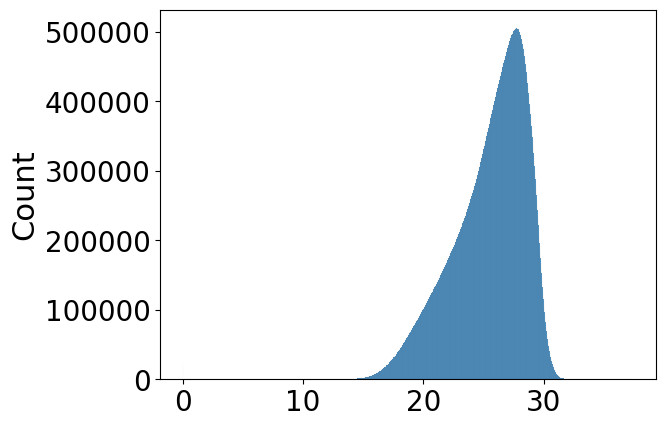

In [96]:
sns.histplot(tos_tropics.to_numpy().flatten())

Is it an issue that SWCRE has so many 0s or is this physical (0 == no clouds).

<Axes: ylabel='Count'>

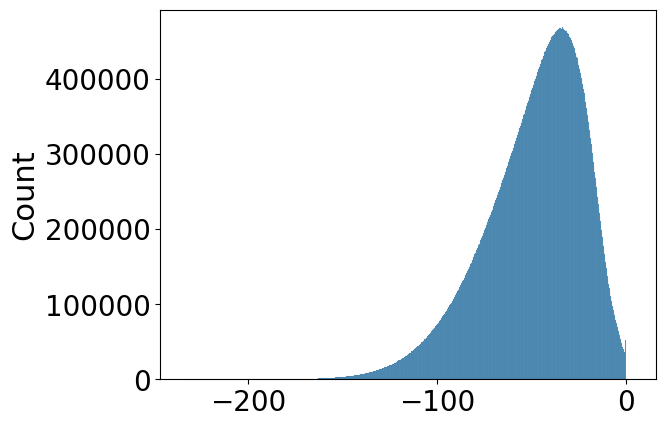

In [182]:
a = swcre_tropics.to_numpy().flatten()
a = a[np.where(~np.isnan(a))]
sns.histplot(a)

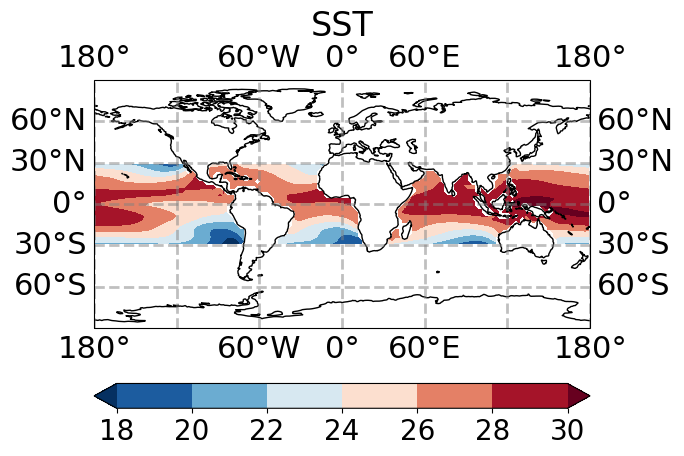

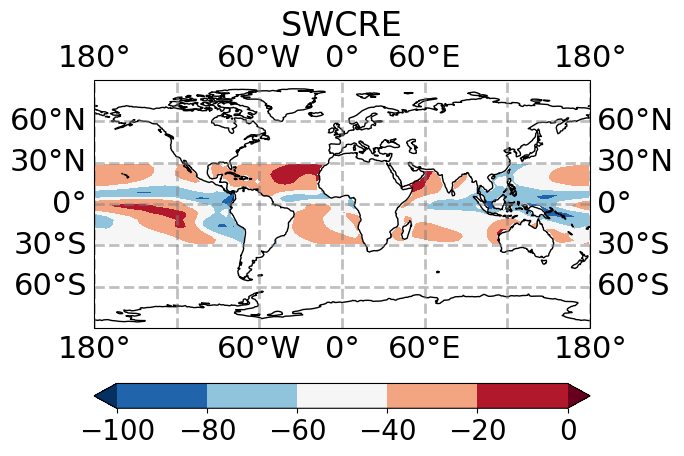

In [94]:
def global_plot(data, lon, lat, cmap, levels, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    im = ax1.contourf(
        lon, lat, data, levels=levels, extend="both", 
        transform=ccrs.PlateCarree(), cmap=cmap
    )
    # Set the extent to 30S - 30N
    ax1.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.coastlines()
    ax1.set_global()
    # Add a horizontal colorbar
    cbar = plt.colorbar(im, orientation='horizontal')
    ax1.set_title(title)
    plt.show()

global_plot(tos_tropics.sel(model="CESM2").mean(["time"]), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SST", levels=8) #np.arange(16, 34, 2))
global_plot(swcre_tropics.sel(model="CESM2").mean(["time"]), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SWCRE", levels=np.arange(-100, 20, 20)) #np.arange(-120, 45, 5))

In [14]:
swcf = xr.open_dataarray("data/swcf_cmip6_monthly_1850-2000.nc", chunks="auto").sel(model="CESM2").sel(lat=slice(-30, 30)).to_numpy().flatten()
tos = xr.open_dataarray("data/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto").sel(model="CESM2").mean(["time"]).sel(lat=slice(-30, 30)).to_numpy().flatten()

Text(0, 0.5, 'Tropical SWCF')

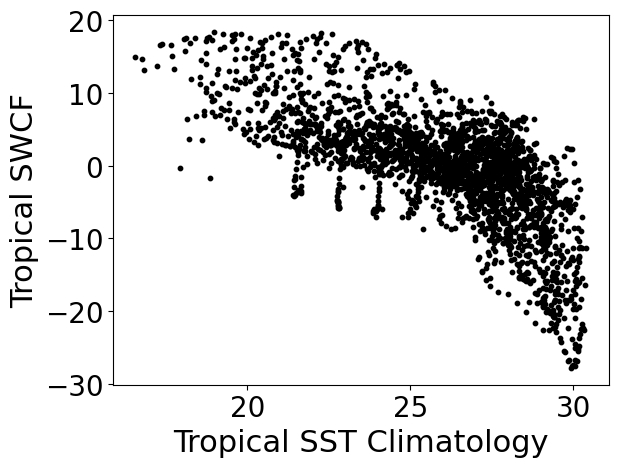

In [19]:
plt.scatter(tos, swcf, s=10, color="black"); plt.xlabel("Tropical SST Climatology"); plt.ylabel("Tropical SWCF")

## Process SST data

In [140]:
def calculate_SSTsharp(
    tos: xr.DataArray, 
    weights: xr.DataArray, 
    window: int = 12*30, 
    era: str = "", 
    step: int = 12, 
    save: bool = False, 
    testing: bool = False,
) -> xr.Dataset:
    """
    - Iterate over each model
    - Calculate SSTsharp package
    - Create sanity check figures
    - Save to netcdf

    Args:
        save (bool, optional): Save the SSTsharp package for each model. Defaults to False.
        testing (bool, optional): If testing, only do first model and 50 time steps. Defaults to False.

    Returns:
        xr.Dataset: Dataset containing SSTsharp package for each model
    """
    models = tos.model.values
    ds = {}
    for model in models:
        print(f"Calculating SST sharpness for {model}")
        if testing:
            model = "HadGEM3-GC31-LL"

        try:
            if save: 
                # Calculate SSTsharp package
                ds_model = do_SSTsharp_sorting(
                    da=tos.sel(model=model), 
                    prctl_bins=prctl_bins, 
                    prctl_binmids=prctl_binmids, 
                    weights=weights
                )
                # Plot SSTsharp package
                # create_percentile_figures(ds_model, model=model)

                # Calculate rolling trend of SSTd
                ds_model_trend = calculate_rolling_trend(ds_model, model=model, window=window, step=step)

                if save:
                    ds_model.to_netcdf(f"data/sharp/{era}/SSTsharp_{model}.nc")
                    ds_model_trend.to_netcdf(f"data/sharp/{era}/SSTsharp_{model}_trend.nc")

                ds[model] = ds_model

            else:
                print(f"Loading SST sharpness for {model}")
                ds[model] = xr.open_dataset(f"data/sharp/{era}/SSTsharp_{model}.nc", chunks="auto")

            if testing: 
                return ds

        except Exception as e:
            print(model, e)
        

    return ds

ds_cmip6 = calculate_SSTsharp(tos=tos_tropics_cmip6, weights=weights_tropics_cmip6, era="cmip6", save=True, testing=False)
ds_cmip5 = calculate_SSTsharp(tos=tos_tropics_cmip5, weights=weights_tropics_cmip5, era="cmip5", save=True, testing=False)


Calculating SST sharpness for E3SM-1-1


Calculating SST sharpness for E3SM-1-0
Calculating SST sharpness for E3SM-1-1-ECA
Calculating SST sharpness for KIOST-ESM
Calculating SST sharpness for CIESM
Calculating SST sharpness for BCC-ESM1
Calculating SST sharpness for BCC-CSM2-MR
Calculating SST sharpness for CESM2-WACCM
Calculating SST sharpness for CESM2-WACCM-FV2
Calculating SST sharpness for CESM2-FV2
Calculating SST sharpness for CESM2
Calculating SST sharpness for FGOALS-f3-L
Calculating SST sharpness for CAS-ESM2-0
Calculating SST sharpness for FGOALS-g3
Calculating SST sharpness for SAM0-UNICON
Calculating SST sharpness for HadGEM3-GC31-LL
Calculating SST sharpness for HadGEM3-GC31-MM
Calculating SST sharpness for GFDL-ESM4
Calculating SST sharpness for GFDL-CM4
Calculating SST sharpness for GISS-E2-2-H
Calculating SST sharpness for GISS-E2-1-H
Calculating SST sharpness for GISS-E2-2-G
Calculating SST sharpness for GISS-E2-1-G
Calculating SST sharpness for IITM-ESM
Calculating SST sharpness for CanESM5
Calculating SST 

### Sanity

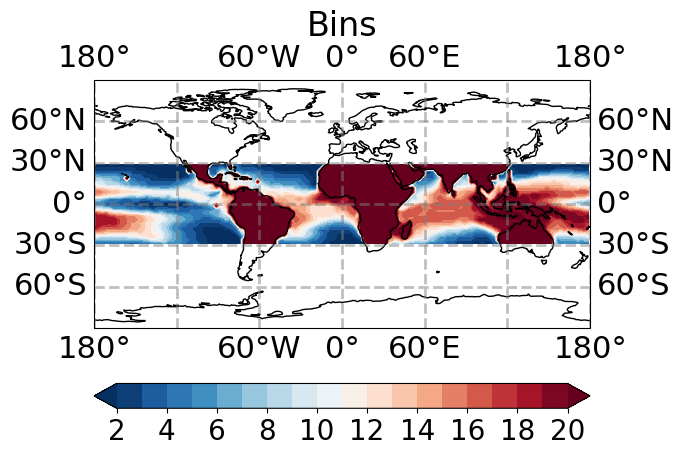

In [167]:
global_plot(ds["sortIdxs"].values.reshape((1800, 24, 144))[0,:,:], lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="Bins", levels=21) 

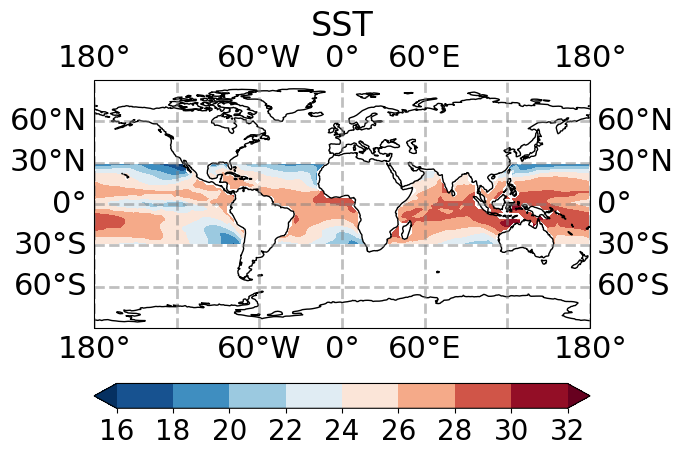

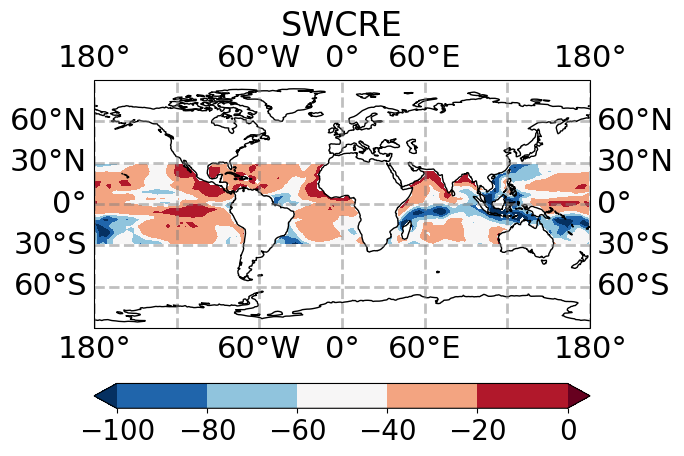

In [169]:
global_plot(tos_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SST", levels=8) #np.arange(16, 34, 2))
global_plot(swcre_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SWCRE", levels=np.arange(-100, 20, 20)) #np.arange(-120, 45, 5))

Text(0, 0.5, 'SWCRE ($Wm^{-2}$)')

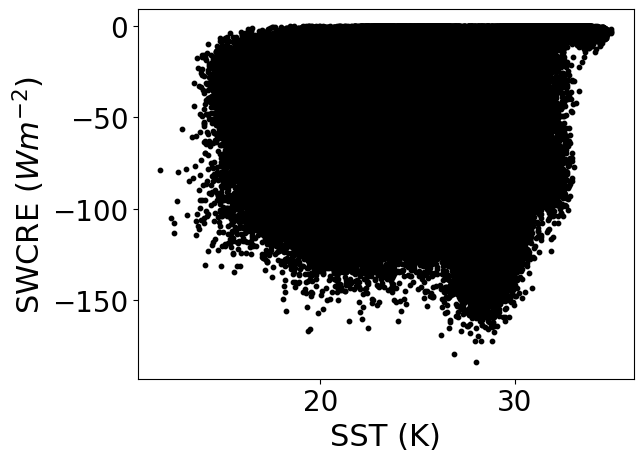

In [187]:
plt.scatter(tos_tropics.sel(model="HadGEM3-GC31-LL").to_numpy().flatten(), swcre_tropics.sel(model="HadGEM3-GC31-LL").to_numpy().flatten(), s=10, color="black")
plt.xlabel("SST (K)"); plt.ylabel(r"SWCRE ($Wm^{-2}$)")
# plt.scatter(tos_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0).values, swcre_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0))

## Process SWCRE data

In [141]:
def calculate_SWCREsharp(
    swcre: xr.DataArray, 
    weights: xr.DataArray, 
    save: bool = False, 
    era: str = "", 
    testing: bool = False
) -> xr.Dataset:
    """_summary_

    Args:
        save (bool, optional): _description_. Defaults to False.
        testing (bool, optional): _description_. Defaults to False.

    Returns:
        xr.Dataset: _description_
    """

    models = swcre.model.values
    swcre_sharp, swcf_sharp = {}, {}
    for model in models:
        print("starting model: ", model)
        if testing: 
            model = "HadGEM3-GC31-LL"

        try:
            if save:
                # Load SSTsharp package
                ds_sharp = xr.open_dataset(f"data/sharp/{era}/SSTsharp_{model}.nc")
                # Grab SWCRE model
                swcre_model = swcre.sel(model=model)

                # One-year low-pass filter 
                # swcre_model = swcre_model.resample(time="Y").mean()
                
                # Calculate SWCREsharp Package
                swcre_sharp[model] = apply_SSTsharp_to_SWCRE(
                    da=swcre_model,
                    ds_sharp=ds_sharp, 
                    prctl_bins=prctl_bins,
                    weights=weights,
                    model=model
                )
                # Create SWCRE figures
                # create_swcre_percentile_figures(swcre_sharp[model], model=model)
                # Save SWCREsharp Package
                swcre_sharp[model].to_netcdf(f"data/sharp/{era}/SWCREsharp_{model}.nc")
                # Calculate SWCF
                swcf_sharp[model] = calculate_swcf_percentiles(SSTsharp=ds_sharp, SWCREsharp=swcre_sharp[model])
                # Calculate SWCF
                # plot_swcf(swcf=swcf_sharp[model], model=model)
                # Save SWCF package
                swcf_sharp[model].to_netcdf(f"data/sharp/{era}/SWCF_{model}.nc")
                # Close SSTsharp package
                ds_sharp.close()
        
        except Exception as e:
            print(model, e)

        if testing:
            return swcre_sharp
   
    return swcre_sharp

swcre_cmip6 = calculate_SWCREsharp(swcre=swcre_tropics_cmip6, weights=weights_tropics_cmip6, era="cmip6", save=True, testing=False)
swcre_cmip5 = calculate_SWCREsharp(swcre=swcre_tropics_cmip5, weights=weights_tropics_cmip5, era="cmip5", save=True, testing=False)

starting model:  EC-Earth3-Veg-LR


starting model:  NorESM2-MM
starting model:  GISS-E2-2-H
starting model:  CESM2-WACCM
starting model:  MPI-ESM1-2-LR
starting model:  BCC-CSM2-MR
starting model:  IITM-ESM
starting model:  CAS-ESM2-0
starting model:  HadGEM3-GC31-MM
starting model:  ACCESS-ESM1-5
starting model:  AWI-CM-1-1-MR
AWI-CM-1-1-MR [Errno 2] No such file or directory: b'/home/espinosa10/tropical_pacific_clouds/data/sharp/cmip6/SSTsharp_AWI-CM-1-1-MR.nc'
starting model:  CIESM
starting model:  HadGEM3-GC31-LL
starting model:  NorESM1-F
starting model:  NorCPM1
starting model:  GISS-E2-1-H
starting model:  EC-Earth3-AerChem
starting model:  INM-CM4-8
starting model:  CESM2
starting model:  CanESM5
starting model:  MRI-ESM2-0
starting model:  EC-Earth3-LR
starting model:  MPI-ESM1-2-HR
starting model:  IPSL-CM6A-LR
starting model:  E3SM-2-0
starting model:  NESM3
starting model:  E3SM-1-0
starting model:  EC-Earth3
starting model:  CMCC-CM2-SR5
starting model:  CanESM5-1
starting model:  GFDL-CM4
starting model: 

# Analysis

## load data generated from processing above

In [185]:
################## Load Shortwave cloud feedback dataset #####################
def load_datasets(era: str = "cmip6") -> Tuple[xr.Dataset, Union(xr.Dataset, Dict), Union(xr.Dataset, Dict), Union(xr.Dataset, Dict)]:
    swcf = {}
    for model_path in glob(f"data/sharp/{era}/SWCF_*.nc"):
        # print(model_path)
        # return
        try:
            model_name = model_path.split("/")[-1].split(".")[0][5:]
            swcf[model_name] = xr.open_dataset(model_path)["binanom"]
        except Exception as e:
            print(model_name, e)

    ds = xr.concat(list(swcf.values()), dim='model')
    ds_swcf = ds.assign_coords(model=list(swcf.keys()))

    ################## Load SST Sharp Trends and SST Sharp #######################
    tos_trends = {}
    tos_sharp = {}

    models = []
    for model in ds_swcf.model.values:
        try: 
            tos_trends[model] = xr.open_dataset(f"data/sharp/{era}/SSTsharp_{model}_trend.nc") 
            tos_sharp[model] = xr.open_dataset(f"data/sharp/{era}/SSTsharp_{model}.nc") 
            models.append(model)
        except Exception as e:
            print(model, e)

    if era != "obs":
        ds_tos_trends = xr.concat(list(tos_trends.values()), dim='model')
        ds_tos_sharp = xr.concat(list(tos_sharp.values()), dim='model')
        # Set the coordinates for the 'model' dimension
        ds_tos_trends = ds_tos_trends.assign_coords(model=models)
        ds_tos_sharp = ds_tos_sharp.assign_coords(model=models)
    else: 
        ds_tos_trends = tos_trends
        ds_tos_sharp = tos_sharp

    ################## Load SWCRE Sharp ########################################
    swcre_sharp = {}

    models = []
    for model in ds_swcf.model.values:
        try: 
            swcre_sharp[model] = xr.open_dataset(f"data/sharp/{era}/SWCREsharp_{model}.nc") 
            models.append(model)
        except Exception as e:
            print(model, e)

    if era != "obs":
        ds_swcre_sharp = xr.concat(list(swcre_sharp.values()), dim='model')
        # Set the coordinates for the 'model' dimension
        ds_swcre_sharp = ds_swcre_sharp.assign_coords(model=models)
    else: 
        ds_swcre_sharp = swcre_sharp
    
    return (ds_swcf, ds_tos_trends, ds_tos_sharp, ds_swcre_sharp)

ds_swcf_cmip6, ds_tos_trends_cmip6, ds_tos_sharp_cmip6, ds_swcre_sharp_cmip6 = load_datasets(era="cmip6")
ds_swcf_cmip5, ds_tos_trends_cmip5, ds_tos_sharp_cmip5, ds_swcre_sharp_cmip5 = load_datasets(era="cmip5")
ds_swcf_obs, ds_tos_trends_obs, ds_tos_sharp_obs, ds_swcre_sharp_obs = load_datasets(era="obs")

## Calculate strength of pattern effect follow Fueglistaler 2019 Figure 1. Multivariate regression between tropical Mean CRE anomaly and SST# and SSTBar. 

We calculate it two different ways: 


Block 1: $\overline{SWCRE} = c_1 \overline{SST} + c_2$ SST# 


Block 2: SST# = $c_3 \overline{SWCRE} + c_4 \overline{SST}$

In [234]:
from sklearn import linear_model
from collections import defaultdict

def plot_SSTsharp_predictions(regs: Dict, model: str) -> None:
    time = regs["SST#"].time
    

    plt.grid()

    # Plot SST#
    plt.plot(time, regs["SST#"], linewidth=3, color="black", label="SST#")
    # Plot SSTBar prediction
    r = np.around(regs["SSTBar_reg"].rvalue, 3)
    plt.plot(time, regs["SSTBar_reg"].intercept + regs["SSTBar_reg"].slope*regs["SSTBar"], 
             label=r"LinReg($\overline{SST}$), "+ f"r={r}"
    )
    # Plot SWCREBar prediction
    r = np.around(regs["SWCREBar_reg"].rvalue, 3)
    plt.plot(time, regs["SWCREBar_reg"].intercept + regs["SWCREBar_reg"].slope*regs["SWCREBar"], 
             label=r"LinReg($\overline{SWCRE}$), " + f"r={r}"
    )
    # Plot SWCRE# prediction
    r = np.around(regs["SWCRE#_reg"].rvalue, 3)
    plt.plot(time, regs["SWCRE#_reg"].intercept + regs["SWCRE#_reg"].slope*regs["SWCRE#"], 
             label=r"LinReg($SWCRE$#), " + f"r={r}"
    )
    # Plot Multivariate prediction
    res = linregress(regs["SST#"], regs["Multi"])
    r = np.around(res.rvalue, 3)
    plt.plot(time, regs["Multi"],
             label=r"LinReg($\overline{SST}$, $\overline{SWCRE}$, $SWCRE$#), " + f"r={r}"
    )
    plt.xlabel("Time (yr)")
    plt.ylabel(r"SST# ($K$)")
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    plt.savefig(f"figures/{model}_sstsharp_prediciton.png")
    plt.clf()


def predict_SSTsharp(tos_sharp: xr.Dataset, swcre_sharp: xr.Dataset, era: str = "", testing: bool = True) -> Dict:
    res = defaultdict(lambda: {})
    if era != "obs": 
        iterator = tos_sharp.model.values 
    else: 
        iterator = list(swcre_sharp.keys())

    for model in iterator:
        # print("Starting: ", model)
        try: 
            if testing: model = "CESM2"
            ############# Load timeseries ###########################
            if era != "obs":
                # Predictand
                res[model]["SST#"] = tos_sharp["sharp"].sel(model=model) # SST# 
                # Predictors
                res[model]["SSTBar"] = tos_sharp["binavg"].sel(model=model).mean(["bins"]) # SST% mean
                res[model]["SWCREBar"] = swcre_sharp["binavg"].sel(model=model).mean(["bins"]) # SWCRE% mean 
                res[model]["SWCRE#"] = swcre_sharp["sharp"].sel(model=model) # SWCRE#
            else: 
                # Predictand
                res[model]["SST#"] = tos_sharp[model]["sharp"] # SST# 
                # Predictors
                res[model]["SSTBar"] = tos_sharp[model]["binavg"].mean(["bins"]) # SST% mean
                res[model]["SWCREBar"] = swcre_sharp[model]["binavg"].mean(["bins"]) # SWCRE% mean 
                res[model]["SWCRE#"] = swcre_sharp[model]["sharp"] # SWCRE#

            # 6 months low pass filter
            res[model]["SST#"] = res[model]["SST#"].resample(time="6M").mean()
            res[model]["SSTBar"] = res[model]["SSTBar"].resample(time="6M").mean()
            res[model]["SWCREBar"] = res[model]["SWCREBar"].resample(time="6M").mean()
            res[model]["SWCRE#"] = res[model]["SWCRE#"].resample(time="6M").mean()
            
            # Normalize (ts - mu / sig)
            # res[model]["SST#"] = (res[model]["SST#"] - res[model]["SST#"].mean()) / res[model]["SST#"].std()
            # res[model]["SSTBar"] = (res[model]["SSTBar"] - res[model]["SSTBar"].mean()) / res[model]["SSTBar"].std()
            # res[model]["SWCREBar"] = (res[model]["SWCREBar"] - res[model]["SWCREBar"].mean()) / res[model]["SWCREBar"].std()
            # res[model]["SWCRE#"] = (res[model]["SWCRE#"] - res[model]["SWCRE#"].mean()) / res[model]["SWCRE#"].std()
            
            ############## BLOCK 1 (Predicting SWCREBar) #############
            ### Single Variable Linear Regression
            res[model]["SSTBar_reg_inv"] = linregress(res[model]["SSTBar"], res[model]["SWCREBar"], )
            res[model]["SST#_reg_inv"] = linregress(res[model]["SST#"], res[model]["SWCREBar"])
            res[model]["SWCRE#_reg_inv"] = linregress(res[model]["SWCRE#"], res[model]["SWCREBar"])
            
            ## Multivariate Linear Regression
            a = np.stack([res[model]["SSTBar"].values, res[model]["SST#"].values, res[model]["SWCRE#"].values]).T
            b = res[model]["SWCREBar"]
            regr = linear_model.LinearRegression()
            regr.fit(a, b)
            res[model]["Multi_inv"] = a[:,0]*regr.coef_[0] + a[:,1]*regr.coef_[1] + a[:,2]*regr.coef_[2]+ regr.intercept_
            res[model]["Multi_regr_inv"] = regr
            res[model]["Multi_reg_inv"] = linregress(res[model]["Multi_inv"], res[model]["SWCREBar"])
            

            ############## BLOCK 2 (Prdicting SST#) #############
            ### Single Variable Linear Regression
            res[model]["SSTBar_reg"] = linregress(res[model]["SSTBar"], res[model]["SST#"])
            res[model]["SWCREBar_reg"] = linregress(res[model]["SWCREBar"], res[model]["SST#"])
            res[model]["SWCRE#_reg"] = linregress(res[model]["SWCRE#"], res[model]["SST#"])

            ## Multivariate Linear Regression
            a = np.stack([res[model]["SSTBar"].values, res[model]["SWCREBar"].values, res[model]["SWCRE#"].values]).T
            b = res[model]["SST#"]
            regr = linear_model.LinearRegression()
            regr.fit(a, b)
            res[model]["Multi"] = a[:,0]*regr.coef_[0] + a[:,1]*regr.coef_[1] + a[:,2]*regr.coef_[2]+ regr.intercept_
            res[model]["Multi_regr"] = regr
            res[model]["Multi_reg"] = linregress(res[model]["Multi"], res[model]["SST#"]) 
            
            if testing: 
                plot_SSTsharp_predictions(regs=res[model], model=model)
                return
            
        except Exception as e: 
            print(model, e) 
    return res

res_cmip6 = predict_SSTsharp(ds_tos_sharp_cmip6, ds_swcre_sharp_cmip6, era="cmip6", testing=False)
res_cmip5 = predict_SSTsharp(ds_tos_sharp_cmip5, ds_swcre_sharp_cmip5, era="cmip5", testing=False)
res_obs = predict_SSTsharp(ds_tos_sharp_obs, ds_swcre_sharp_obs, era="obs", testing=False)

## Calculate dCRE(%)/dSST# (this measures the cloud response to SST changes in the warmest regions - essentially a nonlocal SWCF)

In [144]:
def calculate_nonlocal_swcf_percentiles(SSTsharp: xr.Dataset, SWCREpercentile: xr.Dataset) -> xr.Dataset:
    sstSharp = SSTsharp["sharp"]
    swcre_anoms = SWCREpercentile["binanom"]
    swcf = xscore.linslope(sstSharp, swcre_anoms, dim='time', skipna=True)
    return swcf

def get_nonlocal_swcf_percentiles(swcf: xr.Dataset, tos_sharp: xr.Dataset, swcre_sharp: xr.Dataset) -> xr.Dataset:
    swcf_nonlocal = {}
    for model in swcf.model.values:
        try:
            swcf_nonlocal[model] = calculate_nonlocal_swcf_percentiles(SSTsharp=tos_sharp.sel(model=model), SWCREpercentile=swcre_sharp.sel(model=model))
        except Exception as e:
            print(model, e)
        
    ds_swcf_nonlocal = xr.concat(list(swcf_nonlocal.values()), dim='model')
    # Set the coordinates for the 'model' dimension  
    ds_swcf_nonlocal = ds_swcf_nonlocal.assign_coords(model=list(swcf_nonlocal.keys()))  
    
    return ds_swcf_nonlocal

ds_swcf_nonlocal_cmip6 = get_nonlocal_swcf_percentiles(ds_swcf_cmip6, ds_tos_sharp_cmip6, ds_swcre_sharp_cmip6) 
ds_swcf_nonlocal_cmip5 = get_nonlocal_swcf_percentiles(ds_swcf_cmip5, ds_tos_sharp_cmip5, ds_swcre_sharp_cmip5) 

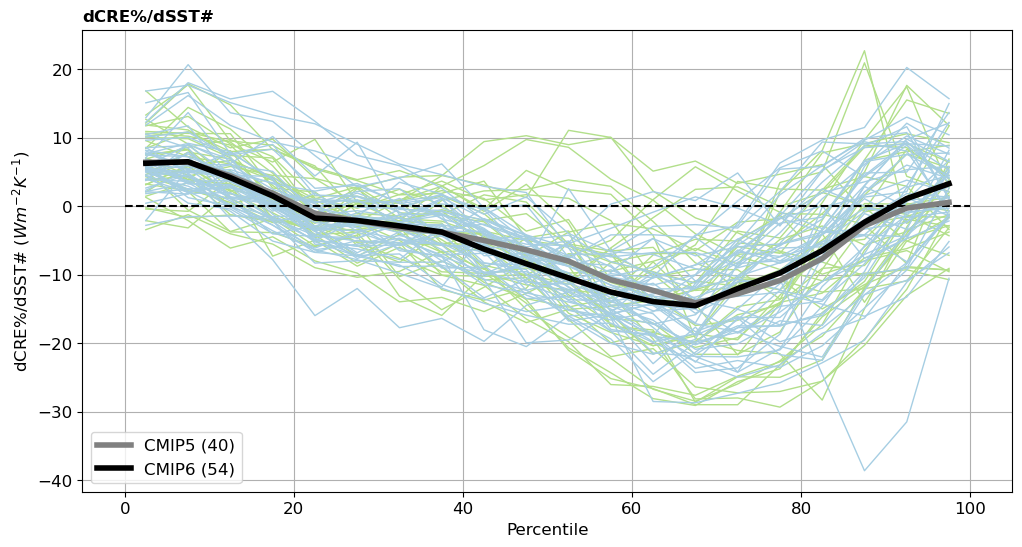

In [163]:
CMIP6_color = "#a6cee3"
CMIP5_color = "#b2df8a" 

# Plot one line for each model 
ds_swcf_nonlocal_cmip5.plot.line(x='bins', hue='model', add_legend=False, color=CMIP5_color, linewidth=1)
ds_swcf_nonlocal_cmip5.mean(["model"]).plot.line(x='bins', add_legend=False, color="gray", linewidth=4, label=r"CMIP5 (40)", zorder=4)

ds_swcf_nonlocal_cmip6.plot.line(x='bins', hue='model', add_legend=False, color=CMIP6_color, linewidth=1)
ds_swcf_nonlocal_cmip6.mean(["model"]).plot.line(x='bins', add_legend=False, color="black", linewidth=4, label="CMIP6 (54)", zorder=4)

plt.title("dCRE%/dSST#", loc="left", fontweight="bold", fontsize=12)
plt.xlabel("Percentile", fontsize=12)
plt.ylabel(r"dCRE%/dSST# ($Wm^{-2}K^{-1}$)", fontsize=12)
plt.legend()
plt.grid()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.hlines([0], xmin=0, xmax=100, linestyle="dashed", color="black")

## SST% vs CRE% (sorted using SST indicies) 
Is this relationship monotonic, does it give us a U-shape, and what does the intermodel spread look like?

In [188]:
ds_swcre_sharp_obs.keys()

dict_keys(['COBE2', 'NOAA_V5', 'ERA5'])

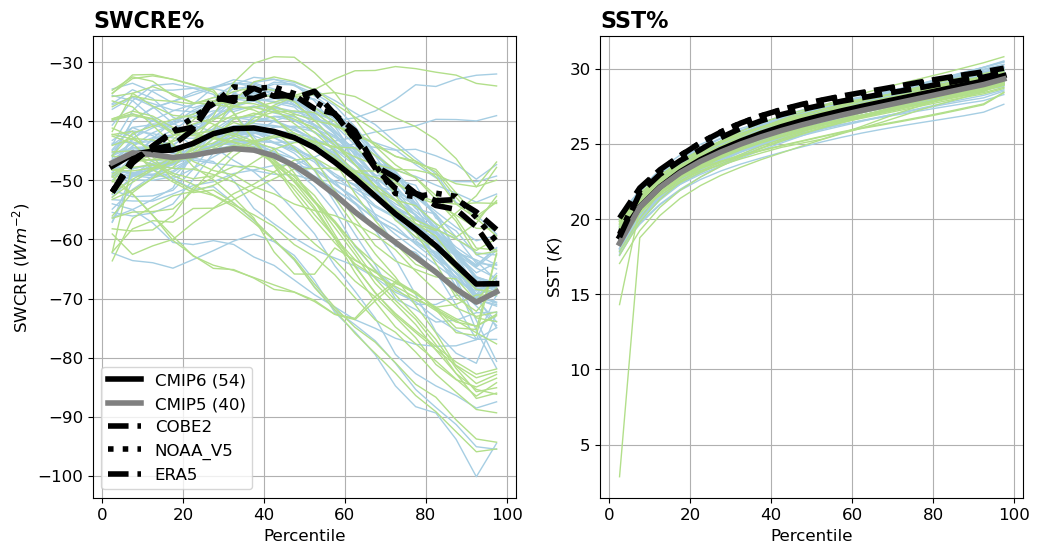

In [193]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ds_swcre_sharp_cmip6["binavg"].mean(["time"]).plot.line(ax=ax1, x="bins", hue='model', add_legend=False, color=CMIP6_color, linewidth=1)
ds_swcre_sharp_cmip6["binavg"].mean(["time","model"]).plot.line(ax=ax1, x='bins', add_legend=False, color="black", label="CMIP6 (54)", linewidth=4, zorder=4)

ds_swcre_sharp_cmip5["binavg"].mean(["time"]).plot.line(ax=ax1, x="bins", hue='model', add_legend=False, color=CMIP5_color, linewidth=1)
ds_swcre_sharp_cmip5["binavg"].mean(["time","model"]).plot.line(ax=ax1, x='bins', add_legend=False, color="gray", label="CMIP5 (40)", linewidth=4, zorder=4)

ds_swcre_sharp_obs["COBE2"]["binavg"].mean(["time"]).plot.line(ax=ax1, x='bins', add_legend=False, linestyle="dashed", color="black", label="COBE2", linewidth=4, zorder=4)
ds_swcre_sharp_obs["NOAA_V5"]["binavg"].mean(["time"]).plot.line(ax=ax1, x='bins', add_legend=False, linestyle=":", color="black", label="NOAA_V5", linewidth=4, zorder=4)
ds_swcre_sharp_obs["ERA5"]["binavg"].mean(["time"]).plot.line(ax=ax1, x='bins', add_legend=False, linestyle="--", color="black", label="ERA5", linewidth=4, zorder=4)

ax1.set_xlabel("Percentile", fontsize=12)
ax1.set_ylabel(r"SWCRE ($Wm^{-2}$)", fontsize=12)
ax1.set_title(r"SWCRE%", loc="left", fontsize=16, fontweight="bold")
ax1.legend()
ax1.grid()

ds_tos_sharp_cmip6["binavg"].mean(["time"]).plot.line(ax=ax2, x="bins", hue='model', add_legend=False, color=CMIP6_color, linewidth=1)
ds_tos_sharp_cmip6["binavg"].mean(["time","model"]).plot.line(ax=ax2, x='bins', add_legend=False, color="black", linewidth=4, zorder=4)

(ds_tos_sharp_cmip5["binavg"].mean(["time"]) - 273.15).plot.line(ax=ax2, x="bins", hue='model', add_legend=False, color=CMIP5_color, linewidth=1)
(ds_tos_sharp_cmip5["binavg"].mean(["time","model"]) - 273.15).plot.line(ax=ax2, x='bins', add_legend=False, color="gray", linewidth=4, zorder=4)

ds_tos_sharp_obs["COBE2"]["binavg"].mean(["time"]).plot.line(ax=ax2, x='bins', add_legend=False, linestyle="dashed", color="black", label="COBE2", linewidth=4, zorder=4)
ds_tos_sharp_obs["NOAA_V5"]["binavg"].mean(["time"]).plot.line(ax=ax2, x='bins', add_legend=False, linestyle=":", color="black", label="NOAA_V5", linewidth=4, zorder=4)
ds_tos_sharp_obs["ERA5"]["binavg"].mean(["time"]).plot.line(ax=ax2, x='bins', add_legend=False, linestyle="--", color="black", label="ERA5", linewidth=4, zorder=4)

ax2.set_xlabel("Percentile", fontsize=12)
ax2.set_ylabel(r"SST ($K$)", fontsize=12)
ax2.set_title(r"SST%", loc="left", fontsize=16, fontweight="bold")
ax2.grid()

## Relationship between SWCF and SST Percentile 

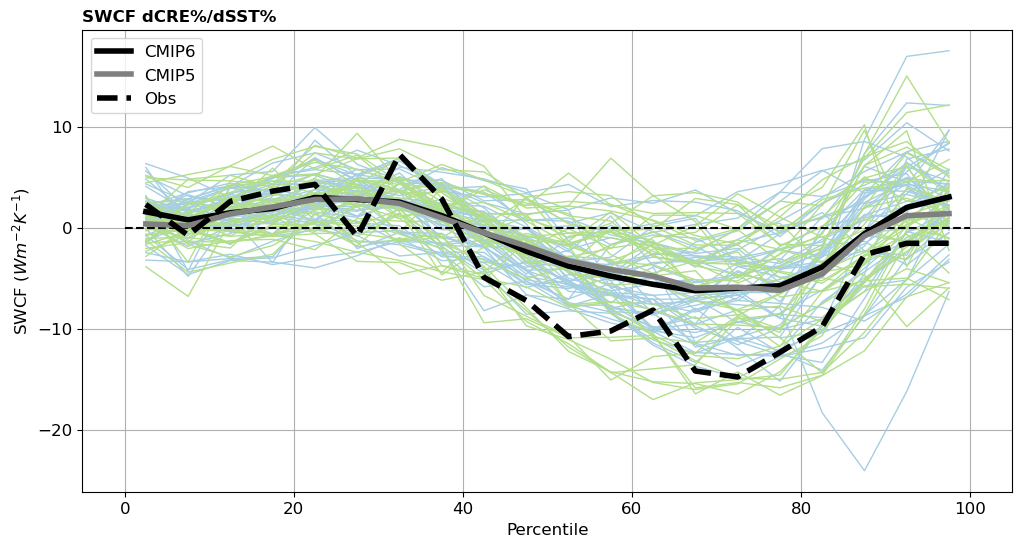

In [197]:
# Plot CMIP6
(ds_swcf_cmip6).plot.line(x='bins', hue='model', add_legend=False, color=CMIP6_color, linewidth=1)
(ds_swcf_cmip6).mean(["model"]).plot.line(x='bins', add_legend=False, color="black", linewidth=4, zorder=4, label="CMIP6")

# Plot CMIP5
(ds_swcf_cmip5).plot.line(x='bins', hue='model', add_legend=False, color=CMIP5_color, linewidth=1)
(ds_swcf_cmip5).mean(["model"]).plot.line(x='bins', add_legend=False, color="gray", linewidth=4, zorder=4, label="CMIP5")

# Plot Observations
# ds_swcf_obs.sel(model="COBE2").plot.line(x='bins', add_legend=False, linestyle="dashed", color="black", label="COBE2", linewidth=4, zorder=4)
# ds_swcf_obs.sel(model="NOAA_V5").plot.line(x='bins', add_legend=False, linestyle=":", color="black", label="NOAA_V5", linewidth=4, zorder=4)
# ds_swcf_obs.sel(model="ERA5").plot.line(x='bins', add_legend=False, linestyle="--", color="black", label="ERA5", linewidth=4, zorder=4)
ds_swcf_obs.mean(["model"]).plot.line(x='bins', add_legend=False, linestyle="--", color="black", label="Obs", linewidth=4, zorder=4)

plt.title("SWCF dCRE%/dSST%", loc="left", fontweight="bold", fontsize=12)
plt.title("")
plt.xlabel("Percentile", fontsize=12)
plt.ylabel(r"SWCF ($Wm^{-2}K^{-1}$)", fontsize=12)
plt.legend()
# plt.ylim(-15, 12)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.hlines([0], xmin=0, xmax=100, linestyle="dashed", color="black")

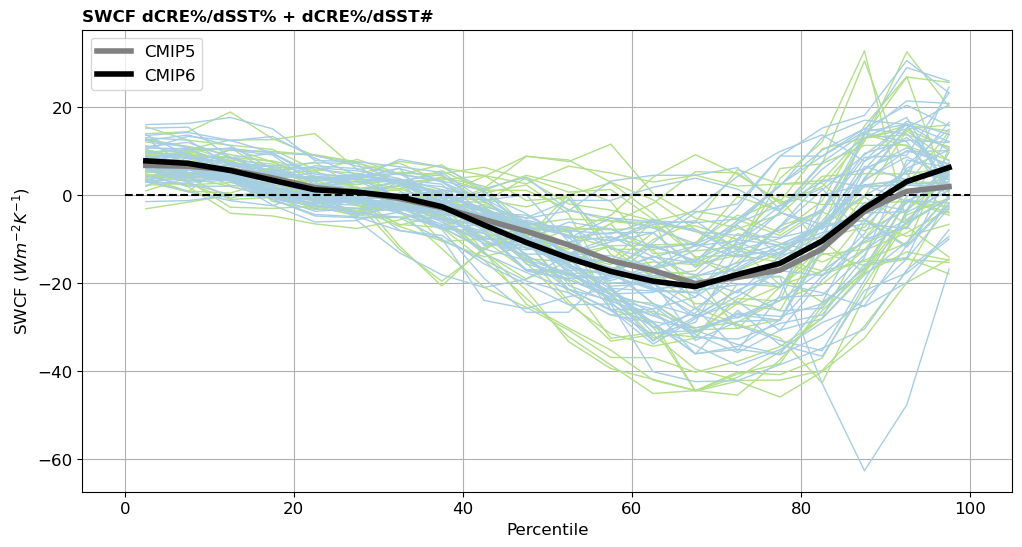

In [168]:
# Plot one line for each model 
(ds_swcf_cmip5 + ds_swcf_nonlocal_cmip5).plot.line(x='bins', hue='model', add_legend=False, color=CMIP5_color, linewidth=1)
(ds_swcf_cmip5 + ds_swcf_nonlocal_cmip5).mean(["model"]).plot.line(x='bins', add_legend=False, color="gray", linewidth=4, zorder=4, label="CMIP5")

(ds_swcf_cmip6 + ds_swcf_nonlocal_cmip6).plot.line(x='bins', hue='model', add_legend=False, color=CMIP6_color, linewidth=1)
(ds_swcf_cmip6 + ds_swcf_nonlocal_cmip6).mean(["model"]).plot.line(x='bins', add_legend=False, color="black", linewidth=4, zorder=4, label="CMIP6")

plt.title("SWCF dCRE%/dSST% + dCRE%/dSST#", loc="left", fontweight="bold", fontsize=12)
plt.xlabel("Percentile", fontsize=12)
plt.ylabel(r"SWCF ($Wm^{-2}K^{-1}$)", fontsize=12)
plt.legend()
# plt.ylim(-15, 12)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.hlines([0], xmin=0, xmax=100, linestyle="dashed", color="black")

## SWCF# and SWCFb vs. variance of 30 year SSTd trend

In [198]:
# def create_scatter(x, y, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
#     plt.scatter(x, y, s=40, edgecolor="black", color="#a6cee3") # , label=x.model.value)
#     plt.scatter(np.mean(x), np.mean(y), s=150, edgecolor="black", color="#a6cee3", marker="x", label="CMIP6")

#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid()

#     x, y  = zip(*sorted(zip(x, y)))
#     slope, intercept, r, p, _ = linregress(x,y)
#     r, p = np.around(r, 3), np.around(p, 3)
#     plt.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--")
#     plt.legend()
    
#     plt.title(left_title, loc="left", fontweight="bold")
#     plt.title(f"{right_title} r={r},p={p}", loc="right", fontweight="bold")

def create_scatter(x6, y6, x5: list = [], y5: list = [], xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
    
    if len(x5) != 0: 
        plt.scatter(x5, y5, s=40, color="#b2df8a", edgecolor="black") # , label=x.model.value)
        plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label="CMIP5")
        
    plt.scatter(x6, y6, s=40, edgecolor="black", color="#a6cee3") # , label=x.model.value)
    plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label="CMIP6")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    plt.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--")
    plt.legend()
    
    plt.title(left_title, loc="left", fontweight="bold")
    plt.title(f"{right_title} r={r},p={p}", loc="right", fontweight="bold")


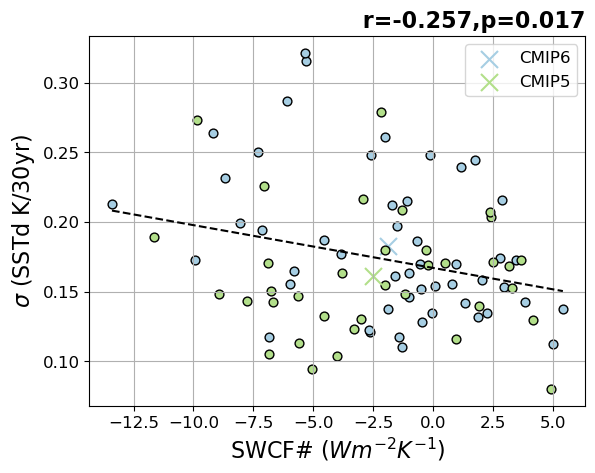

In [171]:
swcf_warmest_cmip6 = ds_swcf_cmip6.sel(bins=slice(70,100)).mean(["bins"], skipna=True)
sstd_trend_cmip6 = (ds_tos_trends_cmip6["SSTd_trend"]*12*30).std(["time"], skipna=True)

swcf_warmest_cmip5 = ds_swcf_cmip5.sel(bins=slice(70,100)).mean(["bins"], skipna=True)
sstd_trend_cmip5 = (ds_tos_trends_cmip5["SSTd_trend"]*12*30).std(["time"], skipna=True)

create_scatter(
    x6=swcf_warmest_cmip6, 
    y6=sstd_trend_cmip6, 
    x5=swcf_warmest_cmip5, 
    y5=sstd_trend_cmip5, 
    xlabel=r"SWCF# ($Wm^{-2}K^{-1}$)", ylabel=r"$\sigma$ (SSTd K/30yr)"
)

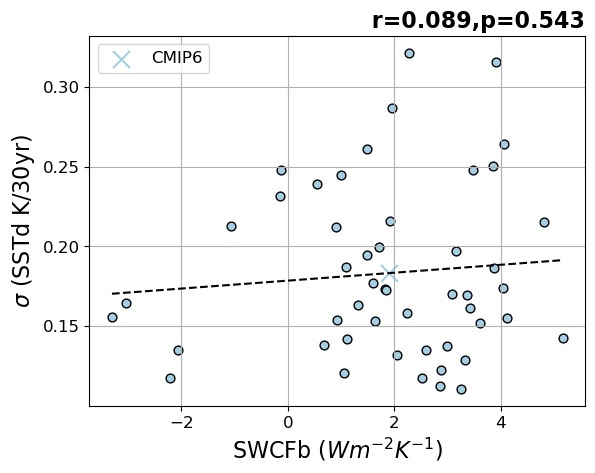

In [61]:
# swcf_coldest = ds_swcf.sel(bins=slice(0,30)).mean(["bins"], skipna=True)
# sstd_trend = (ds_tos_trends["SSTd_trend"]*12*30).std(["time"], skipna=True)
# create_scatter(swcf_coldest, sstd_trend, xlabel=r"SWCF$b$ ($Wm^{-2}K^{-1}$)", ylabel=r"$\sigma$ (SSTd K/30yr)")

## SWCF defined using tropical means vs. Variance of SST#

In [199]:
def calculate_rolling_trend(data: xr.Dataset, model: str = "", window: int = 12*30, step: int = 12) -> xr.Dataset:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.Dataset): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """

    # Calculate SSTd = SSTsharp (warm) - SSTflat (cold)
    SSTd = data["sharp"] - data["flat"]
    SSTsharp = data["sharp"] 
    SSTflat = data["flat"]
    ntime = SSTd.shape[0]

    SSTd_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/12))))
    SSTsharp_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/12))))
    SSTflat_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/12))))
    SSTd_trend.fill(np.nan)
    SSTsharp_trend.fill(np.nan)
    SSTflat_trend.fill(np.nan)

    # Calculate rolling trend of SSTd
    time_idx = xr.DataArray(np.arange(window), dims=("time"))
    for j, i in enumerate(range(0, ntime - window, step)):
        slice_SSTd = SSTd.isel(time=slice(i, int(i+window)))
        slice_SSTsharp = SSTsharp.isel(time=slice(i, int(i+window)))
        slice_SSTflat = SSTflat.isel(time=slice(i, int(i+window)))
        SSTd_trend[j] = xscore.linslope(time_idx, slice_SSTd, dim='time', skipna=True).values
        SSTsharp_trend[j] = xscore.linslope(time_idx, slice_SSTsharp, dim='time', skipna=True).values
        SSTflat_trend[j] = xscore.linslope(time_idx, slice_SSTflat, dim='time', skipna=True).values
    
    # Convert SSTd trend and SSTd to xr.DataArray
    SSTd_trend = xr.DataArray(SSTd_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    SSTsharp_trend = xr.DataArray(SSTsharp_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    SSTflat_trend = xr.DataArray(SSTflat_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    # Convert SSTd to xr.DataArray
    SSTd = xr.DataArray(SSTd, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    SSTsharp= xr.DataArray(SSTsharp, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    SSTflat = xr.DataArray(SSTflat, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    # Combine SSTd and SSTd_trend into xr.Dataset
    ds = xr.Dataset({"SSTd": SSTd, "SSTd_trend": SSTd_trend, "SSTsharp": SSTsharp, "SSTsharp_trend": SSTsharp_trend, "SSTflat": SSTflat, "SSTflat_trend": SSTflat_trend})

    # Sanity plot of SSTd and SSTd_trend
    # sanity_rolling_trend(window=window, sharp=data["sharp"], flat=data["flat"], trend=SSTd_trend*window, raw=SSTd, model=model) 

    return ds


# Load SST Sharp Trend

def get_rolling_trend(ds_swcf, ds_tos_sharp):
    tos_trends_sharp = {}

    for model in ds_swcf.model.values:
        try: 
            tos_trends_sharp[model] = calculate_rolling_trend(ds_tos_sharp.sel(model=model))
        except Exception as e:
            print(model, e)

    ds_tos_trends_sharp = xr.concat(list(tos_trends_sharp.values()), dim='model')
    ds_tos_trends_sharp = ds_tos_trends_sharp.assign_coords(model=list(tos_trends_sharp.keys()))
    return ds_tos_trends_sharp

ds_tos_trends_sharp_cmip6 = get_rolling_trend(ds_swcf_cmip6, ds_tos_sharp_cmip6)
ds_tos_trends_sharp_cmip5 = get_rolling_trend(ds_swcf_cmip5, ds_tos_sharp_cmip5)


In [239]:
def get_reg_values(res: Dict):
    # Multi (Pred SST#)
    r, swcfinv, sstmean = [], [], []
    # Multi (Pred CRE)
    r_bar, swcfinv_bar, sstmean_bar = [], [], []
    # Single 
    sin_sstmean, sin_swcremean, sin_sstmean_bar, sin_sstsharp_bar, sin_sstsharp_bar_coeff = [], [], [], [], []
    for model in list(res.keys()):
        # Multivariate Block 1: Predicting SWCRE from SST# and SST
        r.append(res[model]["Multi_reg"].rvalue)
        swcfinv.append(res[model]["Multi_regr"].coef_[1])
        sstmean.append(res[model]["Multi_regr"].coef_[0])

        # Multivariate Block 2: Predicting SST# from SWCRE and SST
        r_bar.append(res[model]["Multi_reg_inv"].rvalue)
        swcfinv_bar.append(res[model]["Multi_regr_inv"].coef_[1])
        sstmean_bar.append(res[model]["Multi_regr_inv"].coef_[0])

        # Single variate 
        sin_sstmean.append(res[model]["SSTBar_reg"].rvalue)
        sin_swcremean.append(res[model]["SWCREBar_reg"].rvalue)
        sin_sstsharp_bar_coeff.append(res[model]["SST#_reg_inv"].slope)
        sin_sstmean_bar.append(res[model]["SSTBar_reg_inv"].rvalue)
        sin_sstsharp_bar.append(res[model]["SST#_reg_inv"].rvalue)

    swcfinv = np.array(swcfinv)
    sstmean = np.array(sstmean)
    swcfinv_bar = np.array(swcfinv_bar)
    sstmean_bar = np.array(sstmean_bar)
    
    return r, swcfinv, sstmean, r_bar, swcfinv_bar, sstmean_bar, sin_sstmean, sin_swcremean, sin_sstmean_bar, sin_sstmean_bar, sin_sstsharp_bar_coeff

rcmip6 = get_reg_values(res_cmip6)
rcmip5 = get_reg_values(res_cmip5)
robs = get_reg_values(res_obs)

### Block 2: Predicting SST# from SWCRE and SST (inverted form of FUEGLISTALER)

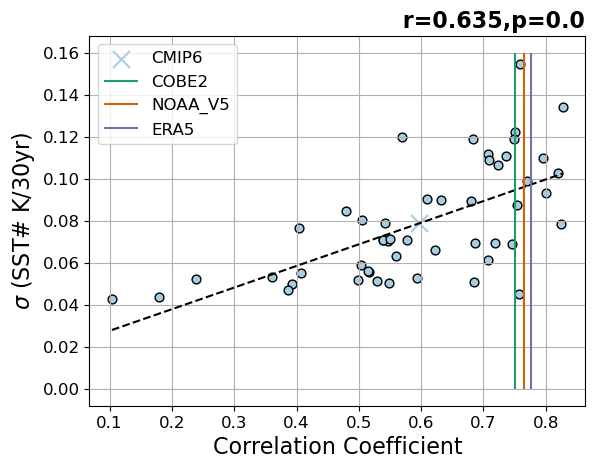

In [240]:
sstsharp_trend_cmip6 = (ds_tos_trends_sharp_cmip6["SSTsharp_trend"]*12*30).std(["time"], skipna=True)
sstsharp_trend_cmip5 = (ds_tos_trends_sharp_cmip5["SSTsharp_trend"]*12*30).std(["time"], skipna=True)

create_scatter(
    x6=rcmip6[0], 
    y6=sstsharp_trend_cmip6, 
    # x5=rcmip5[0],
    # y5=sstsharp_trend_cmip5,
    xlabel=r"Correlation Coefficient", ylabel=r"$\sigma$ (SST# K/30yr)"
)

colors = ['#1b9e77','#d95f02','#7570b3']
for i, key in enumerate(res_obs.keys()):
    plt.vlines(robs[0][i], ymin=0, ymax=.16, label=key, color=colors[i])
plt.legend()

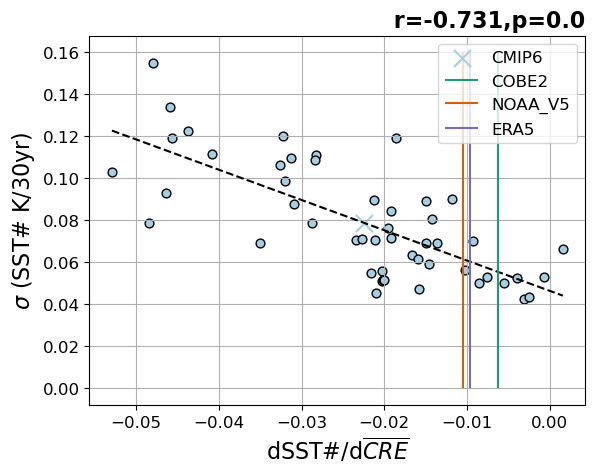

In [241]:
# create_scatter(swcfinv, sstsharp_trend, xlabel=r"dSST#/d$\overliine{CRE}$", ylabel=r"$\sigma$ (SST# K/30yr)")

create_scatter(
    x6=rcmip6[1], 
    y6=sstsharp_trend_cmip6, 
    # x5=rcmip5[1],
    # y5=sstsharp_trend_cmip5,
    xlabel=r"dSST#/d$\overline{CRE}$", ylabel=r"$\sigma$ (SST# K/30yr)"
)

colors = ['#1b9e77','#d95f02','#7570b3']
for i, key in enumerate(res_obs.keys()):
    plt.vlines(robs[1][i], ymin=0, ymax=.16, label=key, color=colors[i])
plt.legend()

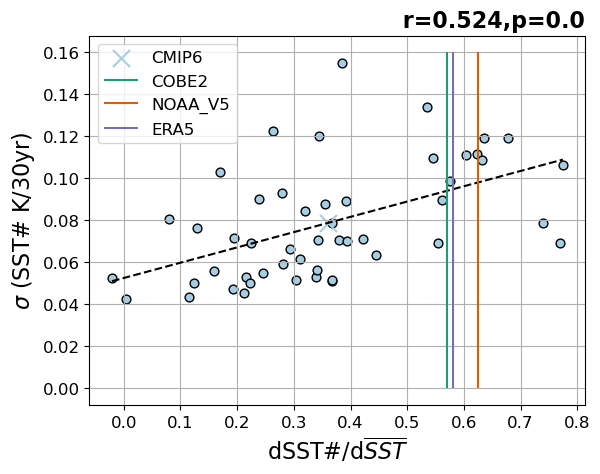

In [242]:
create_scatter(
    x6=rcmip6[2], 
    y6=sstsharp_trend_cmip6, 
    # x5=rcmip5[2],
    # y5=sstsharp_trend_cmip5,
    xlabel=r"dSST#/d$\overline{SST}$", ylabel=r"$\sigma$ (SST# K/30yr)"
)
# plt.vlines(robs[2], ymin=0, ymax=.16)
colors = ['#1b9e77','#d95f02','#7570b3']
for i, key in enumerate(res_obs.keys()):
    plt.vlines(robs[2][i], ymin=0, ymax=.16, label=key, color=colors[i])
plt.legend()

[ 0.13211849  1.95375832  0.90522108  0.10552252 -0.49027479 -1.21250664
  1.36252125 -0.73505144 -0.58525612  0.04344292 -1.43302552 -0.0959493
  0.18325722  0.17723978 -0.33825995  0.04411933 -1.9534904  -0.69912981
 -0.07808687 -0.28030812  1.42589066 -0.24795245  1.63701888 -1.02901562
  0.04319564 -0.08659944  1.25809964 -0.09054293  2.1379912  -0.40570486
  2.1077672  -0.61223297 -0.85231674 -0.40106183  1.11247655  1.40095053
 -0.6938952  -1.82499142  0.32255367 -1.25393505 -0.19926638 -1.18194818
 -0.7566168   0.97141407  1.00573389 -0.96403383 -0.02917482  1.04141701
 -0.84108237]
[ 1.85707867  1.88812608  1.70711224  0.0649802   1.54750335 -1.02314117
  1.32507657 -1.08996391 -0.06784295 -0.16558854 -0.60887441 -1.60010941
 -0.97286319 -0.55130636 -1.7625206  -0.1703041  -1.35732033 -1.24115762
  0.70928652 -0.18395999  1.69188852 -0.48699739 -0.29137089 -0.16630489
  0.45210952 -0.10674907  0.41857522 -0.89684236  0.73839688  1.73332462
  0.91459436 -0.7893052  -0.4948419  -

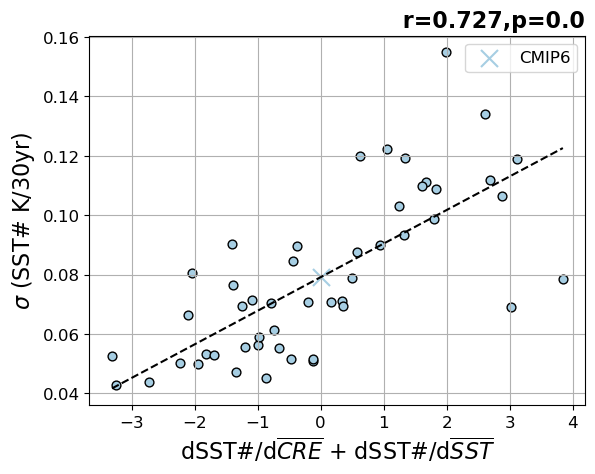

In [79]:
sstmean_norm = (sstmean - np.mean(sstmean)) / np.std(sstmean)
swcfinv_norm = (swcfinv - np.mean(swcfinv)) / np.std(swcfinv)
create_scatter(sstmean_norm + swcfinv_norm, sstsharp_trend, xlabel=r"dSST#/d$\overline{CRE}$ + dSST#/d$\overline{SST}$", ylabel=r"$\sigma$ (SST# K/30yr)")

### Block 1: Predicting SWCRE from SST# and SST (direct form of FUEGLISTALER) - Block 1 and 2 are not necessarily equivalent in their relationship to SST# variance

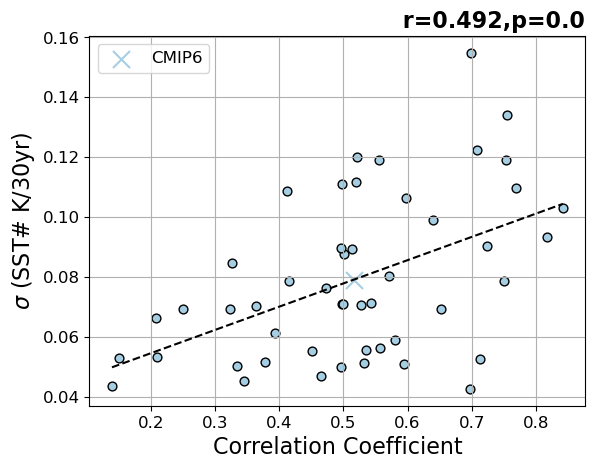

In [81]:
create_scatter(r_bar, sstsharp_trend, xlabel=r"Correlation Coefficient", ylabel=r"$\sigma$ (SST# K/30yr)")

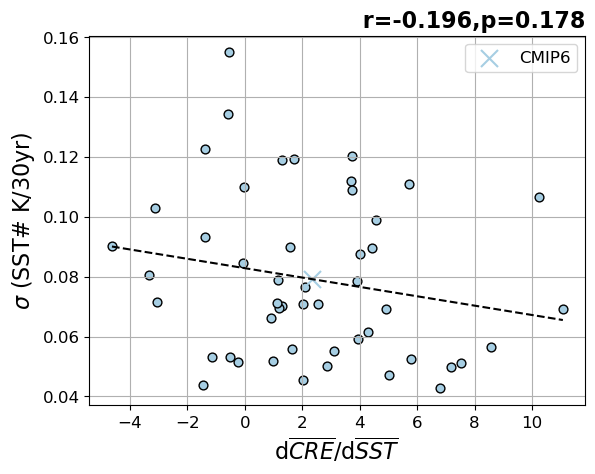

In [87]:
create_scatter(sstmean_bar, sstsharp_trend, xlabel=r"d$\overline{CRE}$/d$\overline{SST}$", ylabel=r"$\sigma$ (SST# K/30yr)")

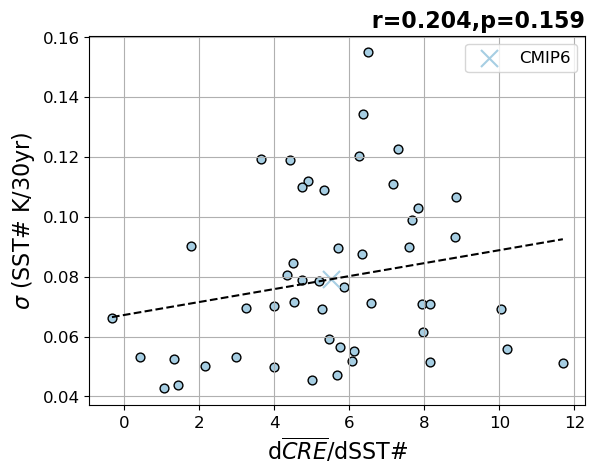

In [85]:
create_scatter(swcfinv_bar, sstsharp_trend, xlabel=r"d$\overline{CRE}$/dSST#", ylabel=r"$\sigma$ (SST# K/30yr)")

### single variable regression

$ SST $# = $c_1 \overline{SWCRE}$


$\overline{SWCRE}$ = $c_2$ $SST$#

# SST# = c_1 SSTBar
create_scatter(x6=sin_sstmean, y6=sstsharp_trend_cmip6, xlabel=r"Correlation Coefficient", ylabel=r"$\sigma$ (SST# K/30yr)")

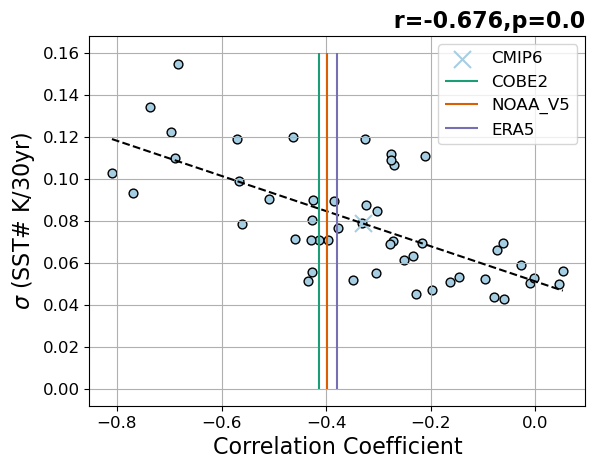

In [243]:
# SST# = c_1 SWCREBar
create_scatter(
    x6=rcmip6[7], 
    y6=sstsharp_trend_cmip6, 
    xlabel=r"Correlation Coefficient", ylabel=r"$\sigma$ (SST# K/30yr)"
)
colors = ['#1b9e77','#d95f02','#7570b3']
for i, key in enumerate(res_obs.keys()):
    plt.vlines(robs[7][i], ymin=0, ymax=.16, label=key, color=colors[i])
plt.legend()

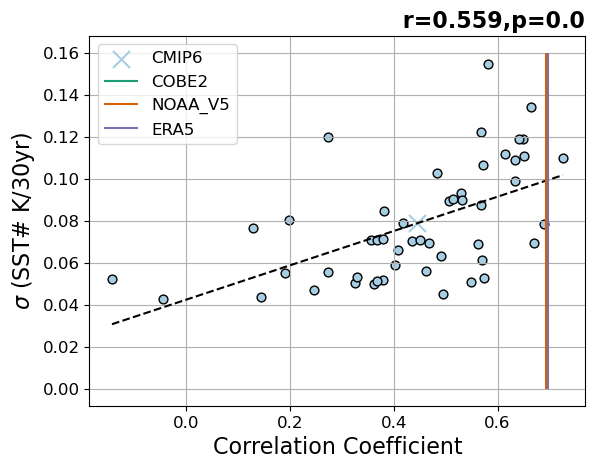

In [244]:
# SST# = c1 SSTbar
create_scatter(
    x6=rcmip6[6], 
    y6=sstsharp_trend_cmip6, 
    xlabel=r"Correlation Coefficient", ylabel=r"$\sigma$ (SST# K/30yr)"
)
colors = ['#1b9e77','#d95f02','#7570b3']
for i, key in enumerate(res_obs.keys()):
    plt.vlines(robs[6][i], ymin=0, ymax=.16, label=key, color=colors[i])
plt.legend()

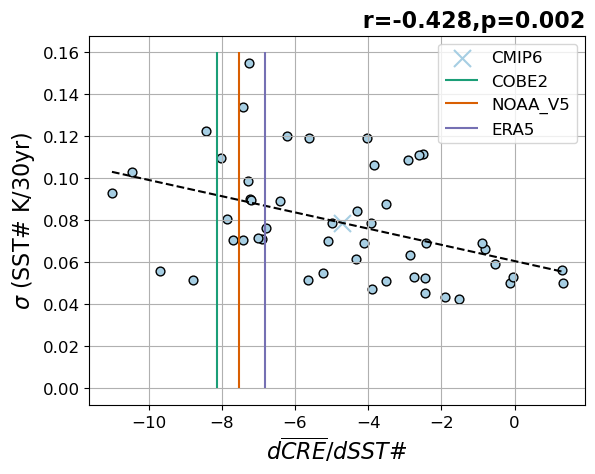

In [245]:
# Coeff for
# CREBar = c1 SST# 
create_scatter(
    x6=rcmip6[-1], #sin_sstsharp_bar_coeff, 
    y6=sstsharp_trend_cmip6,
    # x5=rcmip5[-1], 
    # y5=sstsharp_trend_cmip5,
    xlabel=r"$d\overline{CRE}$/$dSST$# ", ylabel=r"$\sigma$ (SST# K/30yr)"
    )

colors = ['#1b9e77','#d95f02','#7570b3']
for i, key in enumerate(res_obs.keys()):
    plt.vlines(robs[-1][i], ymin=0, ymax=.16, label=key, color=colors[i])
plt.legend()

In [233]:
# SWCREBar = c_3 SSTBar
# create_scatter(sin_sstmean_bar, sstsharp_trend, xlabel=r"Correlation Coefficient", ylabel=r"$\sigma$ (SST# K/30yr)")

### Locally defined SWCF vs. trends

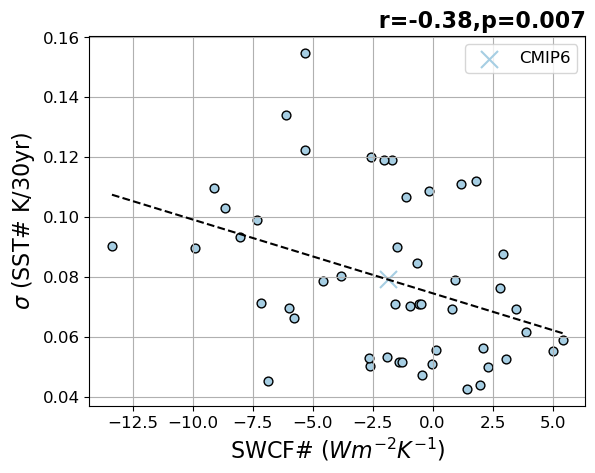

In [182]:
swcf_warmest = ds_swcf.sel(bins=slice(70,100)).mean(["bins"], skipna=True)
sstsharp_trend = (ds_tos_trends_sharp["SSTsharp_trend"]*12*30).std(["time"], skipna=True)
create_scatter(swcf_warmest, sstsharp_trend, xlabel=r"SWCF# ($Wm^{-2}K^{-1}$)", ylabel=r"$\sigma$ (SST# K/30yr)")

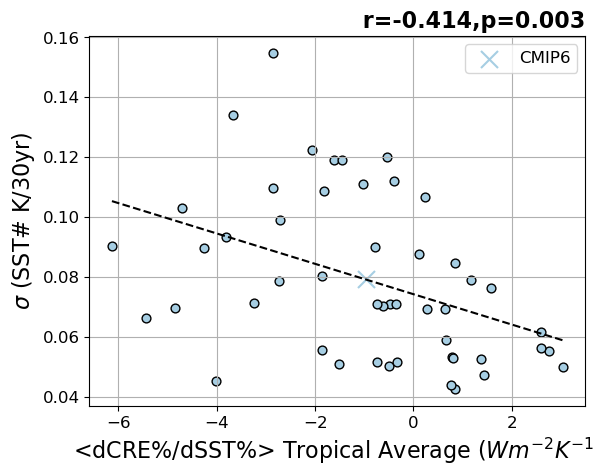

In [109]:
swcf_warmest = ds_swcf.sel(bins=slice(00,100)).mean(["bins"], skipna=True)
sstsharp_trend = (ds_tos_trends_sharp["SSTsharp_trend"]*12*30).std(["time"], skipna=True)
create_scatter(swcf_warmest, sstsharp_trend, xlabel=r"<dCRE%/dSST%> Tropical Average ($Wm^{-2}K^{-1}$)", ylabel=r"$\sigma$ (SST# K/30yr)")

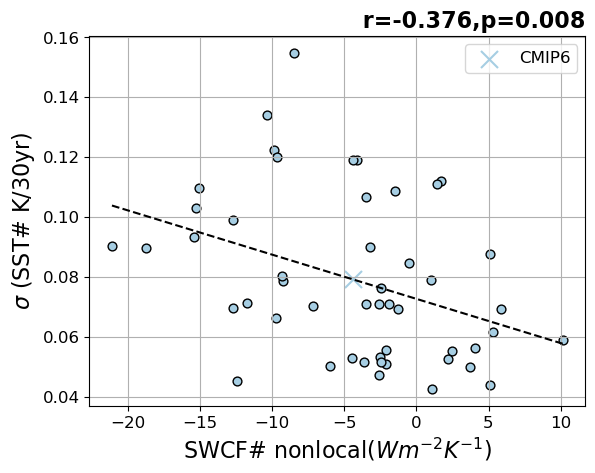

In [92]:
swcf_warmest = ds_swcf_nonlocal.sel(bins=slice(70,100)).mean(["bins"], skipna=True)
sstsharp_trend = (ds_tos_trends_sharp["SSTsharp_trend"]*12*30).std(["time"], skipna=True)
create_scatter(swcf_warmest, sstsharp_trend, xlabel=r"SWCF# nonlocal($Wm^{-2}K^{-1}$)", ylabel=r"$\sigma$ (SST# K/30yr)")

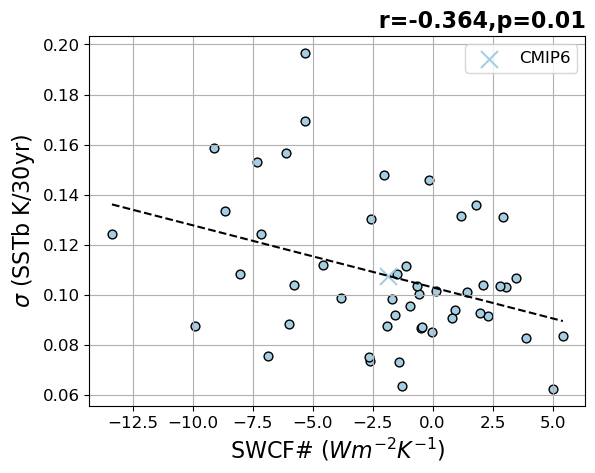

In [78]:
swcf_warmest = ds_swcf.sel(bins=slice(70, 100)).mean(["bins"], skipna=True)
sstflat_trend = (ds_tos_trends_sharp["SSTflat_trend"]*12*30).std(["time"], skipna=True)
create_scatter(swcf_warmest, sstflat_trend, xlabel=r"SWCF# ($Wm^{-2}K^{-1}$)", ylabel=r"$\sigma$ (SSTb K/30yr)")

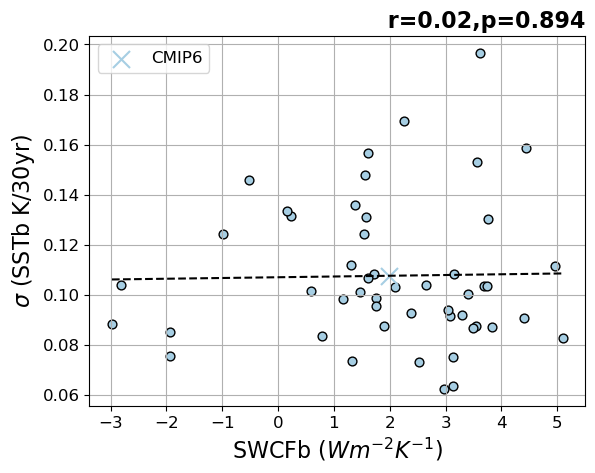

In [74]:
swcf_coldest = ds_swcf.sel(bins=slice(0,35)).mean(["bins"], skipna=True)
sstflat_trend = (ds_tos_trends_sharp["SSTflat_trend"]*12*30).std(["time"], skipna=True)
create_scatter(swcf_coldest, sstflat_trend, xlabel=r"SWCFb ($Wm^{-2}K^{-1}$)", ylabel=r"$\sigma$ (SSTb K/30yr)")

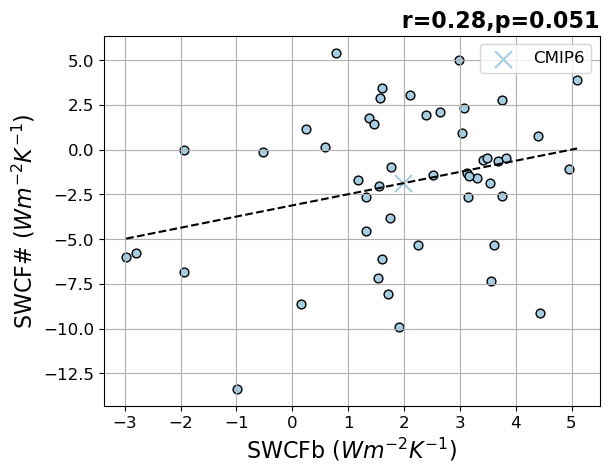

In [75]:
swcf_coldest = ds_swcf.sel(bins=slice(0,35)).mean(["bins"], skipna=True)
swcf_warmest = ds_swcf.sel(bins=slice(70,100)).mean(["bins"], skipna=True)
create_scatter(swcf_coldest, swcf_warmest, xlabel=r"SWCFb ($Wm^{-2}K^{-1}$)", ylabel=r"SWCF# ($Wm^{-2}K^{-1}$)")

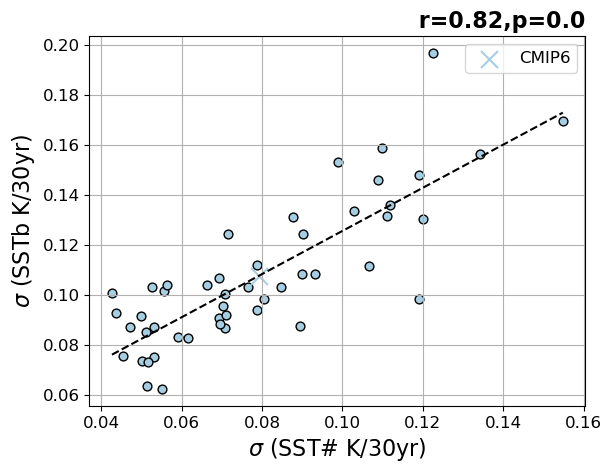

In [76]:
# The 30 year trends in coldest and warmest regions are highly coupled - this is sort of by design because we're removing tropical mean
sstflat_trend = (ds_tos_trends_sharp["SSTflat_trend"]*12*30).std(["time"], skipna=True)
sstsharp_trend = (ds_tos_trends_sharp["SSTsharp_trend"]*12*30).std(["time"], skipna=True)
create_scatter(sstsharp_trend, sstflat_trend, xlabel=r"$\sigma$ (SST# K/30yr)", ylabel=r"$\sigma$ (SSTb K/30yr)")

## Violin Plots of SST# 30yr Trends

In [98]:
def violin_plot_tos(tos, title):
    fig = plt.figure()
    sns.violinplot(data=tos, inner="quartile")
    plt.title(title + r" SST# Trend ($K/30yr$)")
    plt.grid()
    plt.hlines([0], xmin=0, xmax=50, color="black", linestyle="dashed")
    # Rotate the y-axis labels
    plt.tick_params(axis='x', labelrotation=90)
    fig.set_size_inches(20, 5)
    plt.xlabel("")
    plt.ylabel(r"SST# Trend ($K/30yr$)")
    
# violin_plot_tos((ds_tos_trends_sharp["SSTsharp_trend"]*12*30).to_pandas().T, title="CMIP6")

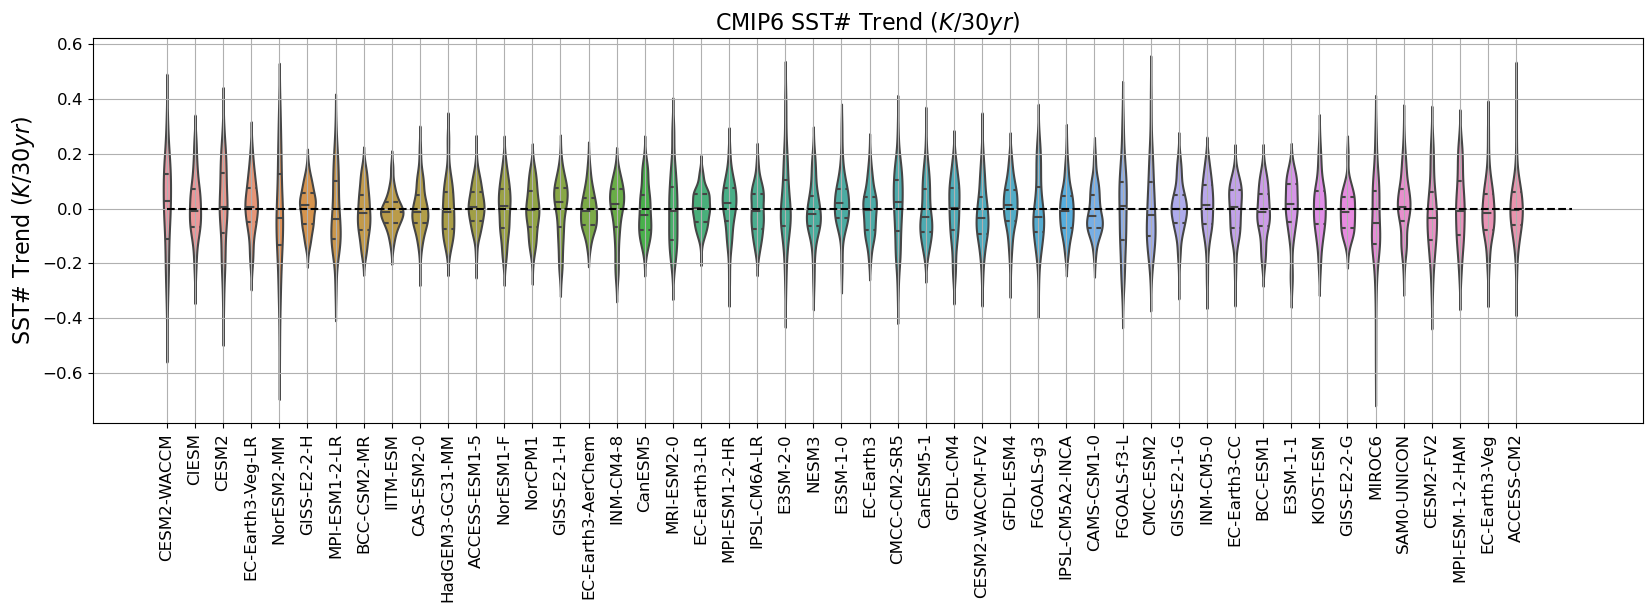

In [99]:
violin_plot_tos((ds_tos_trends_sharp["SSTflat_trend"]*12*30).to_pandas().T, title="CMIP6")

# Extra Analysis

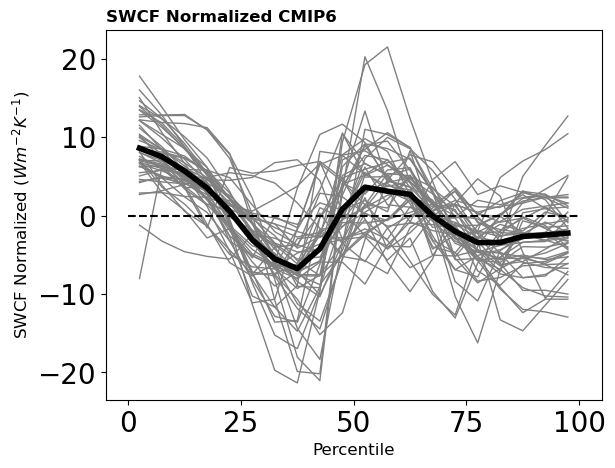

In [106]:
ds_swcf_normalized = ds_swcf - ds_swcf.mean(["bins"])
ds_swcf_normalized.plot.line(x='bins', hue='model', add_legend=False, color="gray", linewidth=1)
ds_swcf_normalized.mean(["model"]).plot.line(x='bins', add_legend=False, color="black", linewidth=4)
plt.title("SWCF Normalized CMIP6", loc="left", fontweight="bold", fontsize=12)
plt.xlabel("Percentile", fontsize=12)
plt.ylabel(r"SWCF Normalized ($Wm^{-2}K^{-1}$)", fontsize=12)
plt.hlines([0], xmin=0, xmax=100, linestyle="dashed", color="black")

In [107]:
def violin_plot_tos(tos, title):
    fig = plt.figure()
    sns.violinplot(data=tos, inner="quartile")
    plt.title(title + r" SST$_{W-E}$ Trend ($K/30yr$)")
    plt.grid()
    # Rotate the y-axis labels
    plt.tick_params(axis='x', labelrotation=90)
    fig.set_size_inches(20, 5)
    plt.xlabel("")
    plt.ylabel(r"SST$_{W-E}$ Trend ($K/30yr$)")